# Ant Colony Optimization for Solving the Traveling Salesman Problem (TSP)

## Introduction
This notebook implements the Ant Colony Optimization (ACO) algorithm to solve the Traveling Salesman Problem (TSP) using a TSPLIB instance. The ACO algorithm is inspired by the foraging behavior of ants, and in this implementation, we visualize the performance of the algorithm as it minimizes the tour cost over iterations. We are using the fl1400 dataset for this assignment.

### Objectives

- Implement ACO for TSP using the TSPLIB library.
- Evaluate and compare the algorithm's performance.

Install and Load Required Libraries

In [ ]:
%%capture
!pip install tsplib95

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import time
import matplotlib.pyplot as plt
import tsplib95
import random

Loading the TSP Instance

The function load_tsp_instance loads a problem instance from the TSPLIB library, which contains real-world TSP problems.

- The tsplib95 library is used to load TSP instances, which provides coordinates of nodes.
- The coordinates of all nodes are extracted and stored in a NumPy array for further processing.
- The function returns both the coordinates and the number of nodes (dimension of the problem).




In [ ]:
# Load the TSP instance
def load_tsp_instance(file_path):
    problem = tsplib95.load(file_path)
    coordinates = np.array([problem.node_coords[i] for i in range(1, problem.dimension + 1)])  # Fixed indexing
    return coordinates

# Example usage
file_path = '/content/fl1400.tsp'
coordinates = load_tsp_instance(file_path)

# Print the loaded coordinates
print("Loaded Coordinates:")
print(coordinates[:10])  # Print the first 10 coordinates for verification


Loaded Coordinates:
[[2104.61  1968.35 ]
 [2104.61   232.264]
 [ 295.591 1968.35 ]
 [ 295.591  232.264]
 [1025.7   1971.3  ]
 [1161.67  1965.39 ]
 [1191.23  1959.49 ]
 [1167.59  1959.49 ]
 [1096.64  1959.49 ]
 [1102.56  1953.58 ]]


Distance Matrix Calculation

This function calculates the pairwise distances between all nodes.

- It uses Euclidean distance between the nodes, calculated using np.linalg.norm().
- The distance matrix is symmetric, so dist_matrix[i][j] = dist_matrix[j][i] to avoid redundant calculations.


 Euclidean Distance Formula

To calculate the distance $ d $ between two points $(x_1, y_1)$ and $ (x_2, y_2) $ in two-dimensional space, use:

$$
d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

Generalized for N-Dimensions

For $n$-dimensional space, the distance between two points $ \mathbf{p} = (p_1, p_2, \ldots, p_n) $ and $ \mathbf{q} = (q_1, q_2, \ldots, q_n) $ can be expressed as:

$$
d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{k=1}^{n} (q_k - p_k)^2}
$$

In [ ]:
# Function to load TSP instance from a file and extract coordinates
def load_tsp_instance(file_path):
    tsp = tsplib95.load(file_path)
    nodes = list(tsp.get_nodes())
    coords = np.array([tsp.node_coords[node] for node in nodes])  # Extract coordinates of nodes
    distance_matrix = np.zeros((len(nodes), len(nodes)))

    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            distance_matrix[i, j] = tsp.get_weight(node1, node2)

    return distance_matrix, coords


Ant Colony Optimization (ACO) Algorithm

The class AntColonyOptimization implements the main ACO logic. It simulates the behavior of ants searching for paths and updating pheromone trails.





Initialization

- num_ants: The number of ants exploring solutions in parallel.
- max_iter: The number of iterations the algorithm will run.
- alpha, beta: Control the influence of pheromones and distances respectively.
- rho: The pheromone evaporation rate.

The pheromone matrix is initialized to ones, meaning initially no paths are favored.

In [ ]:
class AntColonyOptimization:
    def __init__(self, distance_matrix, num_ants, max_iter, alpha=0.1, beta=50, rho=0.99):
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho

        # Initialize pheromone levels
        self.pheromones = np.ones_like(self.distance_matrix)
        self.best_cost_history = []  # Store the best cost history


ACO Algorithm (run method)

The run method is the core of the algorithm, where the ACO process is executed.
It initializes the best solution and cost found so far.
Then, for each iteration, it generates solutions (construct_solutions), calculates their costs, updates the pheromones, and checks if a better solution has been found.
The method tracks the best cost in self.best_cost_history and prints the progress in each iteration.

In [ ]:
def run(self):
    best_cost = float('inf')
    best_solution = None

    for iteration in range(self.max_iter):
        ant_solutions = self.construct_solutions()
        costs = [self.calculate_cost(solution) for solution in ant_solutions]

        # Update pheromones based on the solutions found
        self.update_pheromones(ant_solutions, costs)

        # Check for the best solution
        for i, cost in enumerate(costs):
            if cost < best_cost:
                best_cost = cost
                best_solution = ant_solutions[i]

        # Store the best cost at this iteration
        self.best_cost_history.append(best_cost)
        print(f"Iteration {iteration + 1}/{self.max_iter} - Best Cost: {best_cost}")

    return best_solution, best_cost


Solution Construction (construct_solutions Method)

This method generates solutions for all the ants. For each ant (based on self.num_ants), it builds a solution using the build_solution method and stores it in a list called solutions.

In [ ]:
def construct_solutions(self):
    solutions = []
    for _ in range(self.num_ants):
        solution = self.build_solution()
        solutions.append(solution)
    return solutions


Solution Building (build_solution Method)

The build_solution method constructs a path for each ant.
It randomly chooses a starting node and then, while there are unvisited nodes, calculates the probabilities for each next city using pheromones and distances.
The next city is selected based on these probabilities, and the ant moves to that city until all nodes are visited.

In [ ]:
def build_solution(self):
    num_nodes = len(self.distance_matrix)
    start = random.randint(0, num_nodes - 1)
    visited = [start]
    current = start

    while len(visited) < num_nodes:
        probabilities = self.calculate_probabilities(current, visited)
        next_city = np.random.choice(range(num_nodes), p=probabilities)
        visited.append(next_city)
        current = next_city

    return visited


Pheromone Update

- Pheromones evaporate by multiplying with (1 - rho).
- New pheromones are deposited along the paths based on the quality of the solution (i.e., better paths receive more pheromones).

Pheromone Update Rule
The pheromone update rule is a critical part of the ACO algorithm:

$$
\tau_{ij}^{(t+1)} = (1 - \rho) \cdot \tau_{ij}^{(t)} + \Delta \tau_{ij}^{(t)}
$$

Where:
- $\tau_{ij}^{(t)}$ = Pheromone level on edge $(i, j)$ at iteration $t$
- $\rho$ = Pheromone evaporation rate $(0 < \rho < 1)$
- $\Delta \tau_{ij}^{(t)}$ = Amount of pheromone deposited on edge $(i, j)$ by the ants in iteration $t$

The amount of pheromone deposited can be calculated as:

$$
\Delta \tau_{ij}^{(t)} = \sum_{k=1}^{m} \frac{Q}{L_k}
$$

Where:
- $m$ = Number of ants
- $Q$ = Constant representing the pheromone importance
- $L_k$ = Length of the tour taken by the $k^{th}$ ant



In [ ]:
    def update_pheromones(self, ant_solutions, costs):
        self.pheromones *= (1 - self.rho)  # Evaporate pheromones
        for i, solution in enumerate(ant_solutions):
            for j in range(len(solution) - 1):
                start, end = solution[j], solution[j + 1]
                self.pheromones[start][end] += 1 / costs[i]

Cost Calculation

This method calculates the total distance (cost) of a given ant's path, summing up distances between consecutive nodes in its path.

The total cost (or distance) of a tour can be calculated as follows:

$$
C = \sum_{i=1}^{n} d_{i, i+1} + d_{n, 1}
$$

Where:
- $C$ = Total cost of the tour
- $d_{i, j}$ = Distance between nodes $i$ and $j$
- $n$ = Total number of nodes


In [ ]:
   def calculate_cost(self, solution):
        return sum(self.distance_matrix[solution[i], solution[i + 1]] for i in range(len(solution) - 1))


ACO Main Loop

- The main loop runs for max_iter iterations.
- At each iteration, a set of solutions (one per ant) is generated and evaluated.
- The best solution and its cost are tracked.
- Pheromones are updated based on the quality of the ants' solutions.
- After each iteration, the best cost so far is printed and stored.

### 3. Probability of Choosing Next Node
The probability $P_{ij}$ of an ant moving from node $i$ to node $j$ is given by:

$$
P_{ij} = \frac{\tau_{ij}^\alpha \cdot \eta_{ij}^\beta}{\sum_{k \in \text{allowed}} \tau_{ik}^\alpha \cdot \eta_{ik}^\beta}
$$

Where:
- $\tau_{ij}$ = Pheromone level on edge $(i, j)$
- $\eta_{ij}$ = $\frac{1}{d_{ij}}$ = Visibility (inverse of distance)
- $\alpha$ = Pheromone influence factor
- $\beta$ = Visibility influence factor
- The sum is over all allowed nodes $k$ that the ant can move to from node $i$

In [ ]:
  def calculate_probabilities(self, current, visited):
        pheromone = self.pheromones[current]
        visibility = 1 / (self.distance_matrix[current] + 1e-10)
        probabilities = pheromone ** self.alpha * visibility ** self.beta
        probabilities[visited] = 0  # Avoid visiting already visited nodes
        return probabilities / probabilities.sum()


Plotting Functions

To visualize the progress and final solution.

Plot Best Cost Over Iterations

This function plots the evolution of the best cost over the course of the algorithm's iterations, showing the algorithm's convergence behavior.

In [ ]:
# Function to plot the best cost over iterations and the best solution side by side
def plot_results(best_cost_history, coords, best_solution):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Two subplots, side by side

    # Plot for best cost over iterations
    axs[0].plot(best_cost_history)
    axs[0].set_title('Best Cost Over Iterations')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Cost')
    axs[0].grid(True)



Plot the TSP Solution

This function visualizes the final TSP solution by plotting the nodes and connecting them according to the best-found tour. The nodes are highlighted in red, and the path is drawn in blue.

In [ ]:
 # Plot for the best path with nodes
    x = [coords[i][0] for i in best_solution]
    y = [coords[i][1] for i in best_solution]
    axs[1].plot(x, y, 'bo-', label='Path')
    axs[1].plot(x, y, 'ro-', label='Best Path')
    axs[1].set_title('Best Path')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

Running the ACO Algorithm

- This block runs the ACO algorithm with 50 ants and 100 iterations.
- After the algorithm finishes, it plots the evolution of the best cost and the final TSP solution graph.

In [ ]:
# Example usage
if __name__ == "__main__":
    # Load the TSP instance
    file_path = '/content/fl1400.tsp'  # Update this with the correct path to your TSP file
    distance_matrix, coords = load_tsp_instance(file_path)

    aco = AntColonyOptimization(distance_matrix, num_ants=30, max_iter=100)
    best_solution, best_cost = aco.run()

    print("Best Solution:", best_solution)
    print("Best Cost:", best_cost)

    # Plot the results (best cost history and best solution path)
    plot_results(aco.best_cost_history, coords, best_solution)


# Full code

Iteration 1/50 - Best Cost: 67808.0
Iteration 2/50 - Best Cost: 67808.0
Iteration 3/50 - Best Cost: 66906.0
Iteration 4/50 - Best Cost: 65480.0
Iteration 5/50 - Best Cost: 65480.0
Iteration 6/50 - Best Cost: 65480.0
Iteration 7/50 - Best Cost: 64907.0
Iteration 8/50 - Best Cost: 64907.0
Iteration 9/50 - Best Cost: 63072.0
Iteration 10/50 - Best Cost: 63072.0
Iteration 11/50 - Best Cost: 63072.0
Iteration 12/50 - Best Cost: 63072.0
Iteration 13/50 - Best Cost: 63072.0
Iteration 14/50 - Best Cost: 63072.0
Iteration 15/50 - Best Cost: 60680.0
Iteration 16/50 - Best Cost: 57691.0
Iteration 17/50 - Best Cost: 51544.0
Iteration 18/50 - Best Cost: 47805.0
Iteration 19/50 - Best Cost: 42564.0
Iteration 20/50 - Best Cost: 38013.0
Iteration 21/50 - Best Cost: 37431.0
Iteration 22/50 - Best Cost: 36681.0
Iteration 23/50 - Best Cost: 36681.0
Iteration 24/50 - Best Cost: 35137.0
Iteration 25/50 - Best Cost: 33964.0
Iteration 26/50 - Best Cost: 33669.0
Iteration 27/50 - Best Cost: 33669.0
Iteration 

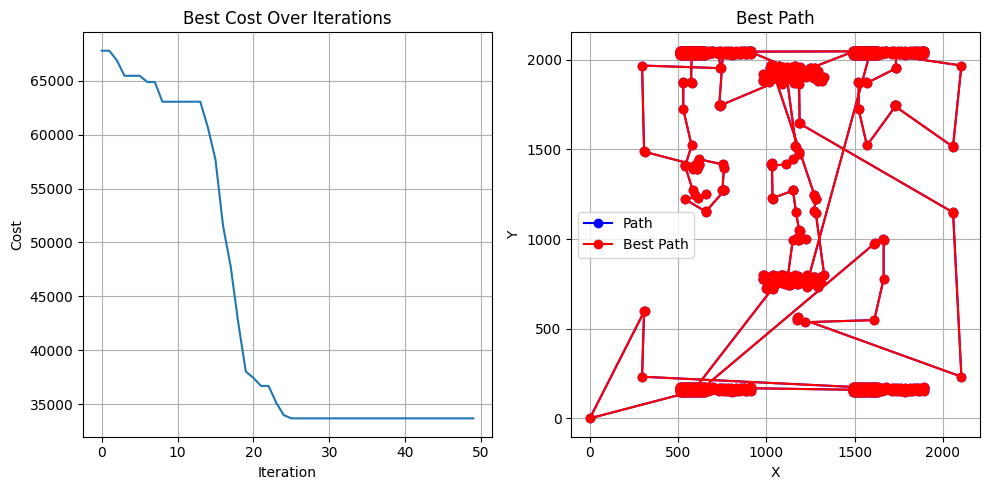

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tsplib95
import time  # Import the time module

class AntColonyOptimization:
    def __init__(self, distance_matrix, num_ants, max_iter, alpha=1.0, beta=2, rho=0.5):
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho

        # Initialize pheromone levels
        self.pheromones = np.ones_like(self.distance_matrix)
        self.best_cost_history = []  # Store the best cost history

    def run(self):
        best_cost = float('inf')
        best_solution = None

        start_time = time.time()  # Record the start time

        for iteration in range(self.max_iter):
            ant_solutions = self.construct_solutions()
            costs = [self.calculate_cost(solution) for solution in ant_solutions]

            # Update pheromones based on the solutions found
            self.update_pheromones(ant_solutions, costs)

            # Check for the best solution
            for i, cost in enumerate(costs):
                if cost < best_cost:
                    best_cost = cost
                    best_solution = ant_solutions[i]

            # Store the best cost at this iteration
            self.best_cost_history.append(best_cost)
            print(f"Iteration {iteration + 1}/{self.max_iter} - Best Cost: {best_cost}")

        elapsed_time = time.time() - start_time  # Calculate elapsed time
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")  # Print elapsed time

        return best_solution, best_cost

    def construct_solutions(self):
        solutions = []
        for _ in range(self.num_ants):
            solution = self.build_solution()
            solutions.append(solution)
        return solutions

    def build_solution(self):
        num_nodes = len(self.distance_matrix)
        start = random.randint(0, num_nodes - 1)
        visited = [start]
        current = start

        while len(visited) < num_nodes:
            probabilities = self.calculate_probabilities(current, visited)
            next_city = np.random.choice(range(num_nodes), p=probabilities)
            visited.append(next_city)
            current = next_city

        return visited

    def calculate_probabilities(self, current, visited):
        pheromone = self.pheromones[current]
        visibility = 1 / (self.distance_matrix[current] + 1e-10)
        probabilities = pheromone ** self.alpha * visibility ** self.beta
        probabilities[visited] = 0  # Avoid visiting already visited nodes
        return probabilities / probabilities.sum()

    def update_pheromones(self, ant_solutions, costs):
        self.pheromones *= (1 - self.rho)  # Evaporate pheromones
        for i, solution in enumerate(ant_solutions):
            for j in range(len(solution) - 1):
                start, end = solution[j], solution[j + 1]
                self.pheromones[start][end] += 1 / costs[i]

    def calculate_cost(self, solution):
        return sum(self.distance_matrix[solution[i], solution[i + 1]] for i in range(len(solution) - 1))

# Function to load TSP instance from a file and extract coordinates
def load_tsp_instance(file_path):
    tsp = tsplib95.load(file_path)
    nodes = list(tsp.get_nodes())
    coords = np.array([tsp.node_coords[node] for node in nodes])  # Extract coordinates of nodes
    distance_matrix = np.zeros((len(nodes), len(nodes)))

    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            distance_matrix[i, j] = tsp.get_weight(node1, node2)

    return distance_matrix, coords

# Function to plot the best cost over iterations and the best solution side by side
def plot_results(best_cost_history, coords, best_solution):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Two subplots, side by side

    # Plot for best cost over iterations
    axs[0].plot(best_cost_history)
    axs[0].set_title('Best Cost Over Iterations')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Cost')
    axs[0].grid(True)

    # Plot for the best path with nodes
    x = [coords[i][0] for i in best_solution]
    y = [coords[i][1] for i in best_solution]
    axs[1].plot(x, y, 'bo-', label='Path')
    axs[1].plot(x, y, 'ro-', label='Best Path')
    axs[1].set_title('Best Path')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load the TSP instance
    file_path = '/content/fl1400.tsp'
    distance_matrix, coords = load_tsp_instance(file_path)

    aco = AntColonyOptimization(distance_matrix, num_ants=20, max_iter=50)
    best_solution, best_cost = aco.run()

    print("Best Solution:", best_solution)
    print("Best Cost:", best_cost)

    # Plot the results (best cost history and best solution path)
    plot_results(aco.best_cost_history, coords, best_solution)


The initial parameters for the ACO algorithm were set as alpha = 1.0, beta = 2, and rho = 0.5. However, this configuration yielded suboptimal performance, resulting in a total cost of 33,669.0. These results indicate the necessity of fine-tuning the parameters to achieve more optimal outcomes.

#  Parameter Tuning

Testing alpha=0.1, beta=2.0, rho=0.5
Iteration 1/50 - Best Cost: 66684.0
Iteration 2/50 - Best Cost: 65386.0
Iteration 3/50 - Best Cost: 65386.0
Iteration 4/50 - Best Cost: 65386.0
Iteration 5/50 - Best Cost: 65386.0
Iteration 6/50 - Best Cost: 65386.0
Iteration 7/50 - Best Cost: 65386.0
Iteration 8/50 - Best Cost: 65386.0
Iteration 9/50 - Best Cost: 64827.0
Iteration 10/50 - Best Cost: 64827.0
Iteration 11/50 - Best Cost: 64827.0
Iteration 12/50 - Best Cost: 59138.0
Iteration 13/50 - Best Cost: 59138.0
Iteration 14/50 - Best Cost: 59138.0
Iteration 15/50 - Best Cost: 59138.0
Iteration 16/50 - Best Cost: 59138.0
Iteration 17/50 - Best Cost: 59138.0
Iteration 18/50 - Best Cost: 59138.0
Iteration 19/50 - Best Cost: 59138.0
Iteration 20/50 - Best Cost: 59138.0
Iteration 21/50 - Best Cost: 59138.0
Iteration 22/50 - Best Cost: 57799.0
Iteration 23/50 - Best Cost: 57799.0
Iteration 24/50 - Best Cost: 57799.0
Iteration 25/50 - Best Cost: 57799.0
Iteration 26/50 - Best Cost: 56281.0
Iteration 

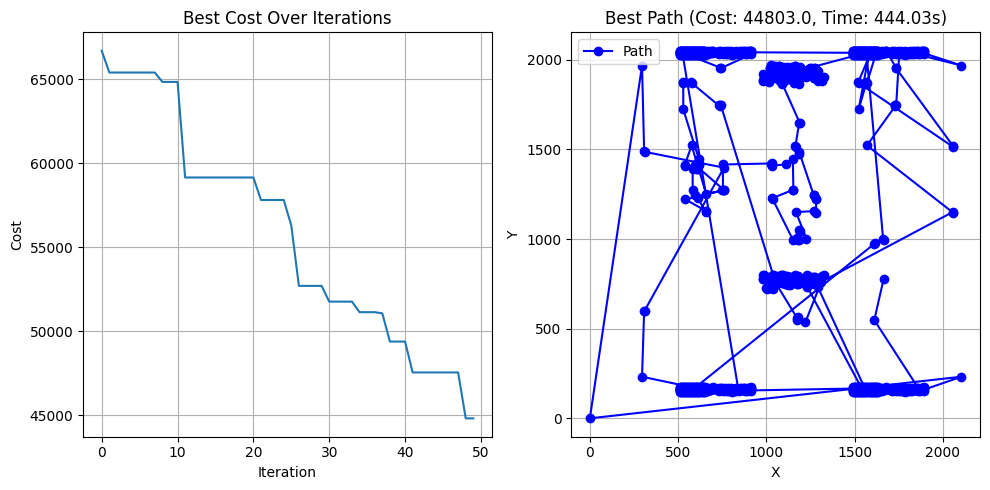

Testing alpha=0.1, beta=2.0, rho=0.1
Iteration 1/50 - Best Cost: 67025.0
Iteration 2/50 - Best Cost: 67025.0
Iteration 3/50 - Best Cost: 66839.0
Iteration 4/50 - Best Cost: 66839.0
Iteration 5/50 - Best Cost: 64473.0
Iteration 6/50 - Best Cost: 64473.0
Iteration 7/50 - Best Cost: 64473.0
Iteration 8/50 - Best Cost: 64473.0
Iteration 9/50 - Best Cost: 64473.0
Iteration 10/50 - Best Cost: 64473.0
Iteration 11/50 - Best Cost: 64473.0
Iteration 12/50 - Best Cost: 64473.0
Iteration 13/50 - Best Cost: 64473.0
Iteration 14/50 - Best Cost: 64473.0
Iteration 15/50 - Best Cost: 64473.0
Iteration 16/50 - Best Cost: 64473.0
Iteration 17/50 - Best Cost: 64473.0
Iteration 18/50 - Best Cost: 64473.0
Iteration 19/50 - Best Cost: 64473.0
Iteration 20/50 - Best Cost: 64473.0
Iteration 21/50 - Best Cost: 64473.0
Iteration 22/50 - Best Cost: 64473.0
Iteration 23/50 - Best Cost: 64473.0
Iteration 24/50 - Best Cost: 64473.0
Iteration 25/50 - Best Cost: 64473.0
Iteration 26/50 - Best Cost: 64473.0
Iteration 

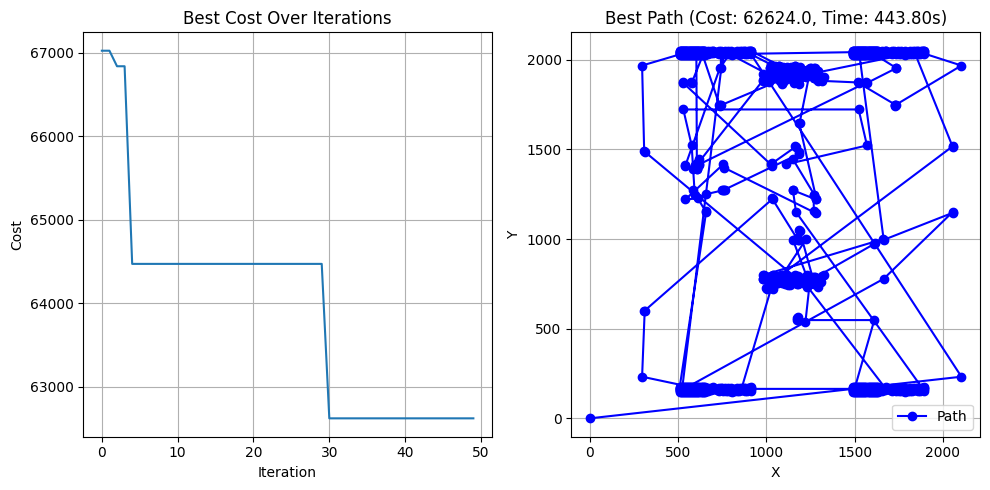

Testing alpha=0.1, beta=2.0, rho=0.9
Iteration 1/50 - Best Cost: 69468.0
Iteration 2/50 - Best Cost: 66748.0
Iteration 3/50 - Best Cost: 66748.0
Iteration 4/50 - Best Cost: 66748.0
Iteration 5/50 - Best Cost: 66748.0
Iteration 6/50 - Best Cost: 65313.0
Iteration 7/50 - Best Cost: 63807.0
Iteration 8/50 - Best Cost: 61379.0
Iteration 9/50 - Best Cost: 57690.0
Iteration 10/50 - Best Cost: 55243.0
Iteration 11/50 - Best Cost: 53355.0
Iteration 12/50 - Best Cost: 53355.0
Iteration 13/50 - Best Cost: 50495.0
Iteration 14/50 - Best Cost: 49323.0
Iteration 15/50 - Best Cost: 45763.0
Iteration 16/50 - Best Cost: 45763.0
Iteration 17/50 - Best Cost: 45763.0
Iteration 18/50 - Best Cost: 43893.0
Iteration 19/50 - Best Cost: 43893.0
Iteration 20/50 - Best Cost: 40336.0
Iteration 21/50 - Best Cost: 40336.0
Iteration 22/50 - Best Cost: 40336.0
Iteration 23/50 - Best Cost: 40336.0
Iteration 24/50 - Best Cost: 38063.0
Iteration 25/50 - Best Cost: 38063.0
Iteration 26/50 - Best Cost: 38063.0
Iteration 

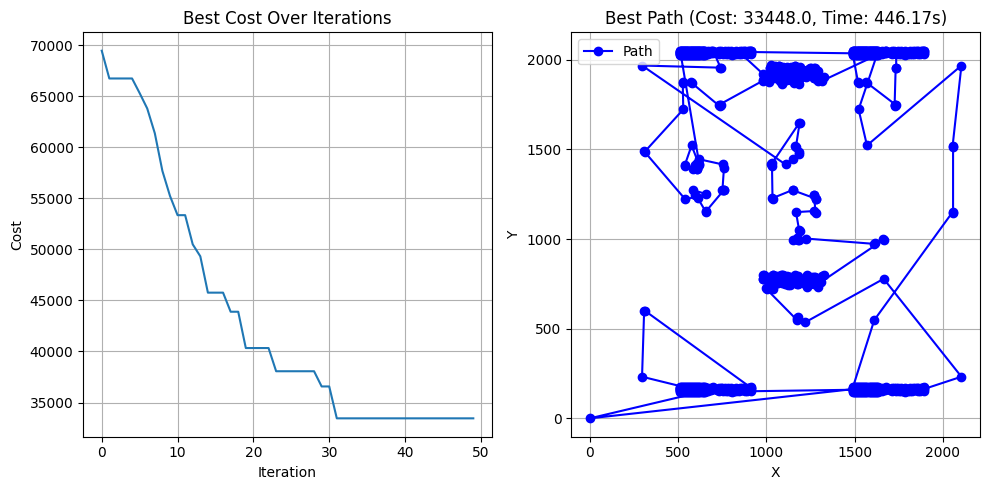

Testing alpha=0.1, beta=50, rho=0.5


<ipython-input-47-64cdd6932ed4>:72: RuntimeWarning: overflow encountered in power
  probabilities = pheromone ** self.alpha * visibility ** self.beta


Iteration 1/50 - Best Cost: 23933.0
Iteration 2/50 - Best Cost: 23933.0
Iteration 3/50 - Best Cost: 23569.0
Iteration 4/50 - Best Cost: 23569.0
Iteration 5/50 - Best Cost: 23569.0
Iteration 6/50 - Best Cost: 23569.0
Iteration 7/50 - Best Cost: 23569.0
Iteration 8/50 - Best Cost: 23569.0
Iteration 9/50 - Best Cost: 23497.0
Iteration 10/50 - Best Cost: 23497.0
Iteration 11/50 - Best Cost: 23497.0
Iteration 12/50 - Best Cost: 23497.0
Iteration 13/50 - Best Cost: 23497.0
Iteration 14/50 - Best Cost: 23497.0
Iteration 15/50 - Best Cost: 23497.0
Iteration 16/50 - Best Cost: 23497.0
Iteration 17/50 - Best Cost: 23497.0
Iteration 18/50 - Best Cost: 23497.0
Iteration 19/50 - Best Cost: 23497.0
Iteration 20/50 - Best Cost: 23497.0
Iteration 21/50 - Best Cost: 23497.0
Iteration 22/50 - Best Cost: 23497.0
Iteration 23/50 - Best Cost: 23497.0
Iteration 24/50 - Best Cost: 23497.0
Iteration 25/50 - Best Cost: 23497.0
Iteration 26/50 - Best Cost: 23497.0
Iteration 27/50 - Best Cost: 23497.0
Iteration 

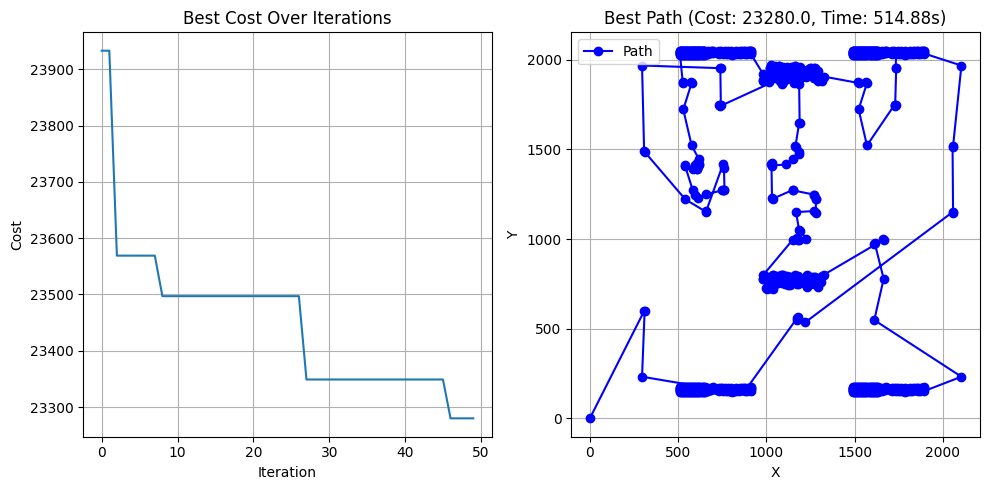

Testing alpha=0.1, beta=50, rho=0.1
Iteration 1/50 - Best Cost: 24182.0
Iteration 2/50 - Best Cost: 23514.0
Iteration 3/50 - Best Cost: 23514.0
Iteration 4/50 - Best Cost: 23514.0
Iteration 5/50 - Best Cost: 23309.0
Iteration 6/50 - Best Cost: 23309.0
Iteration 7/50 - Best Cost: 23226.0
Iteration 8/50 - Best Cost: 23226.0
Iteration 9/50 - Best Cost: 23226.0
Iteration 10/50 - Best Cost: 23226.0
Iteration 11/50 - Best Cost: 23226.0
Iteration 12/50 - Best Cost: 23226.0
Iteration 13/50 - Best Cost: 23226.0
Iteration 14/50 - Best Cost: 23226.0
Iteration 15/50 - Best Cost: 23226.0
Iteration 16/50 - Best Cost: 23226.0
Iteration 17/50 - Best Cost: 23226.0
Iteration 18/50 - Best Cost: 23226.0
Iteration 19/50 - Best Cost: 23226.0
Iteration 20/50 - Best Cost: 23226.0
Iteration 21/50 - Best Cost: 23226.0
Iteration 22/50 - Best Cost: 23226.0
Iteration 23/50 - Best Cost: 23226.0
Iteration 24/50 - Best Cost: 23226.0
Iteration 25/50 - Best Cost: 23226.0
Iteration 26/50 - Best Cost: 23226.0
Iteration 2

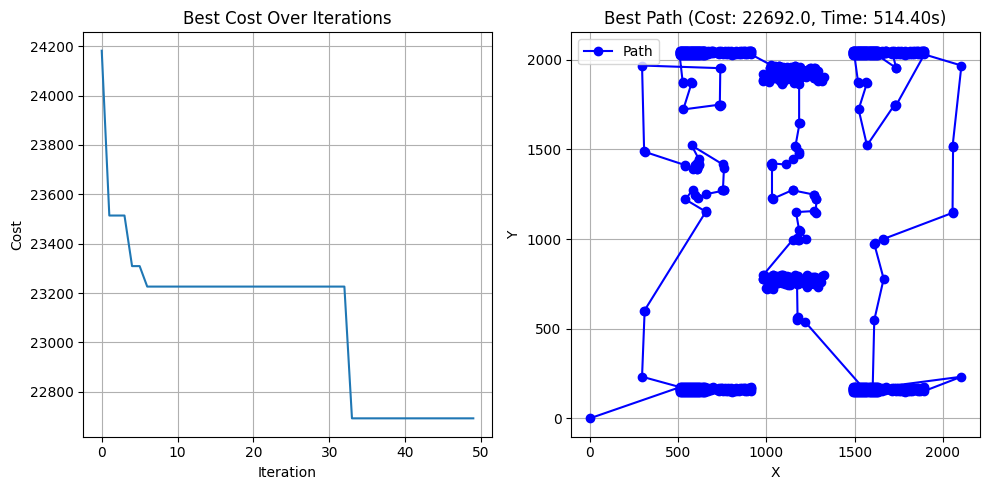

Testing alpha=0.1, beta=50, rho=0.9
Iteration 1/50 - Best Cost: 23336.0
Iteration 2/50 - Best Cost: 23336.0
Iteration 3/50 - Best Cost: 23336.0
Iteration 4/50 - Best Cost: 23336.0
Iteration 5/50 - Best Cost: 22713.0
Iteration 6/50 - Best Cost: 22713.0
Iteration 7/50 - Best Cost: 22713.0
Iteration 8/50 - Best Cost: 22713.0
Iteration 9/50 - Best Cost: 22713.0
Iteration 10/50 - Best Cost: 22713.0
Iteration 11/50 - Best Cost: 22713.0
Iteration 12/50 - Best Cost: 22713.0
Iteration 13/50 - Best Cost: 22713.0
Iteration 14/50 - Best Cost: 22713.0
Iteration 15/50 - Best Cost: 22713.0
Iteration 16/50 - Best Cost: 22713.0
Iteration 17/50 - Best Cost: 22713.0
Iteration 18/50 - Best Cost: 22713.0
Iteration 19/50 - Best Cost: 22713.0
Iteration 20/50 - Best Cost: 22713.0
Iteration 21/50 - Best Cost: 22713.0
Iteration 22/50 - Best Cost: 22713.0
Iteration 23/50 - Best Cost: 22713.0
Iteration 24/50 - Best Cost: 22713.0
Iteration 25/50 - Best Cost: 22713.0
Iteration 26/50 - Best Cost: 22713.0
Iteration 2

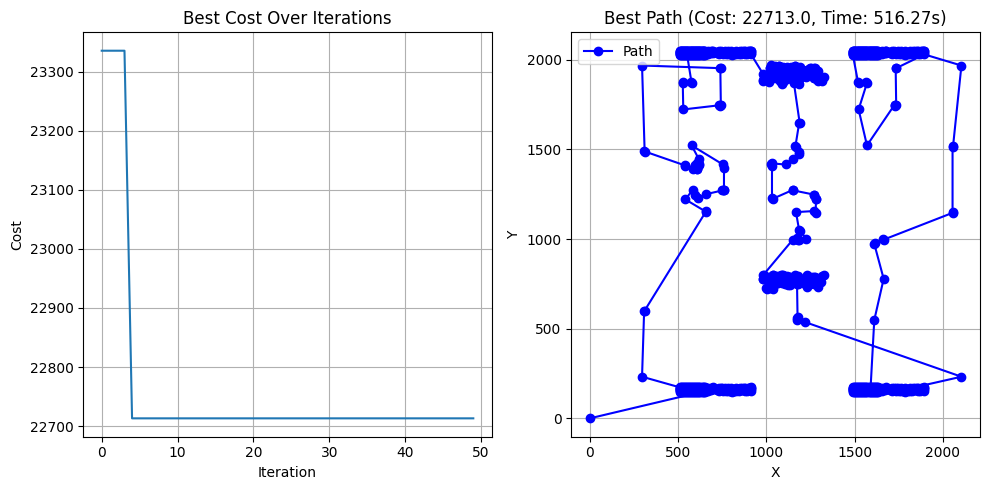

Testing alpha=0.1, beta=5.0, rho=0.5
Iteration 1/50 - Best Cost: 30058.0
Iteration 2/50 - Best Cost: 30058.0
Iteration 3/50 - Best Cost: 29312.0
Iteration 4/50 - Best Cost: 29312.0
Iteration 5/50 - Best Cost: 29312.0
Iteration 6/50 - Best Cost: 29312.0
Iteration 7/50 - Best Cost: 29312.0
Iteration 8/50 - Best Cost: 29312.0
Iteration 9/50 - Best Cost: 29312.0
Iteration 10/50 - Best Cost: 29312.0
Iteration 11/50 - Best Cost: 29312.0
Iteration 12/50 - Best Cost: 29312.0
Iteration 13/50 - Best Cost: 29312.0
Iteration 14/50 - Best Cost: 29312.0
Iteration 15/50 - Best Cost: 27096.0
Iteration 16/50 - Best Cost: 27096.0
Iteration 17/50 - Best Cost: 27096.0
Iteration 18/50 - Best Cost: 27096.0
Iteration 19/50 - Best Cost: 27096.0
Iteration 20/50 - Best Cost: 27096.0
Iteration 21/50 - Best Cost: 27096.0
Iteration 22/50 - Best Cost: 27096.0
Iteration 23/50 - Best Cost: 27096.0
Iteration 24/50 - Best Cost: 27096.0
Iteration 25/50 - Best Cost: 27096.0
Iteration 26/50 - Best Cost: 27096.0
Iteration 

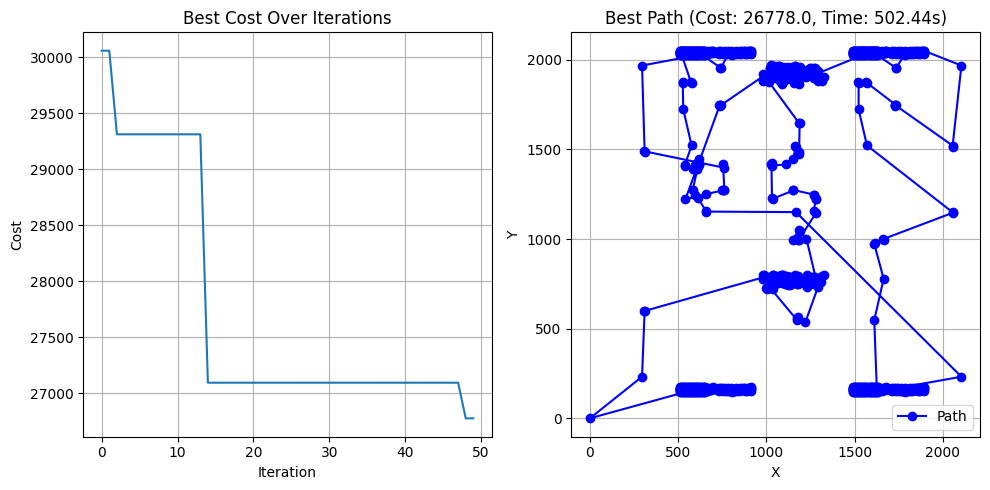

Testing alpha=0.1, beta=5.0, rho=0.1
Iteration 1/50 - Best Cost: 30567.0
Iteration 2/50 - Best Cost: 30453.0
Iteration 3/50 - Best Cost: 30058.0
Iteration 4/50 - Best Cost: 29191.0
Iteration 5/50 - Best Cost: 29191.0
Iteration 6/50 - Best Cost: 29191.0
Iteration 7/50 - Best Cost: 29191.0
Iteration 8/50 - Best Cost: 29191.0
Iteration 9/50 - Best Cost: 29142.0
Iteration 10/50 - Best Cost: 29142.0
Iteration 11/50 - Best Cost: 29142.0
Iteration 12/50 - Best Cost: 29142.0
Iteration 13/50 - Best Cost: 29142.0
Iteration 14/50 - Best Cost: 29142.0
Iteration 15/50 - Best Cost: 29142.0
Iteration 16/50 - Best Cost: 29142.0
Iteration 17/50 - Best Cost: 29142.0
Iteration 18/50 - Best Cost: 29142.0
Iteration 19/50 - Best Cost: 29142.0
Iteration 20/50 - Best Cost: 29142.0
Iteration 21/50 - Best Cost: 29142.0
Iteration 22/50 - Best Cost: 29142.0
Iteration 23/50 - Best Cost: 29142.0
Iteration 24/50 - Best Cost: 29142.0
Iteration 25/50 - Best Cost: 29142.0
Iteration 26/50 - Best Cost: 28825.0
Iteration 

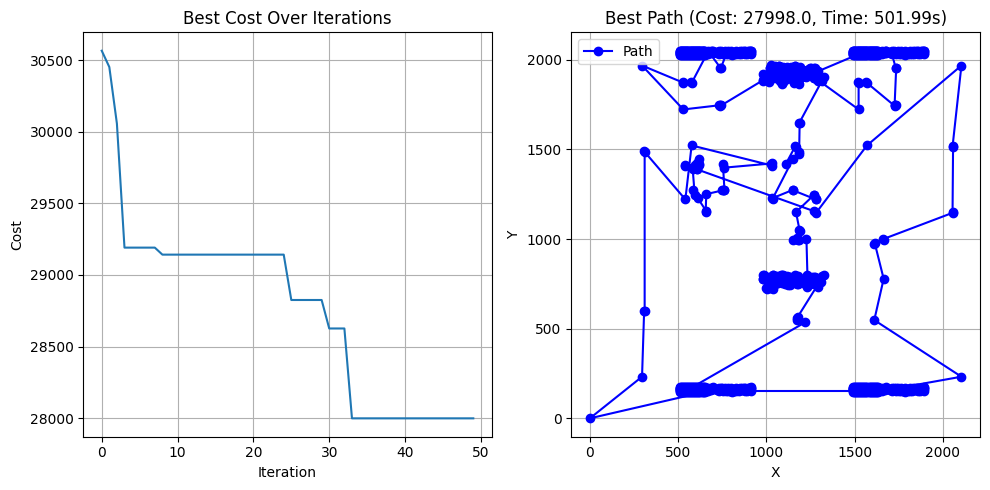

Testing alpha=0.1, beta=5.0, rho=0.9
Iteration 1/50 - Best Cost: 28740.0
Iteration 2/50 - Best Cost: 28740.0
Iteration 3/50 - Best Cost: 28740.0
Iteration 4/50 - Best Cost: 28740.0
Iteration 5/50 - Best Cost: 28740.0
Iteration 6/50 - Best Cost: 28740.0
Iteration 7/50 - Best Cost: 28740.0
Iteration 8/50 - Best Cost: 28323.0
Iteration 9/50 - Best Cost: 27993.0
Iteration 10/50 - Best Cost: 27993.0
Iteration 11/50 - Best Cost: 27494.0
Iteration 12/50 - Best Cost: 27494.0
Iteration 13/50 - Best Cost: 27494.0
Iteration 14/50 - Best Cost: 27494.0
Iteration 15/50 - Best Cost: 27418.0
Iteration 16/50 - Best Cost: 27418.0
Iteration 17/50 - Best Cost: 27418.0
Iteration 18/50 - Best Cost: 27418.0
Iteration 19/50 - Best Cost: 26159.0
Iteration 20/50 - Best Cost: 26159.0
Iteration 21/50 - Best Cost: 26159.0
Iteration 22/50 - Best Cost: 26159.0
Iteration 23/50 - Best Cost: 26159.0
Iteration 24/50 - Best Cost: 25743.0
Iteration 25/50 - Best Cost: 25743.0
Iteration 26/50 - Best Cost: 25743.0
Iteration 

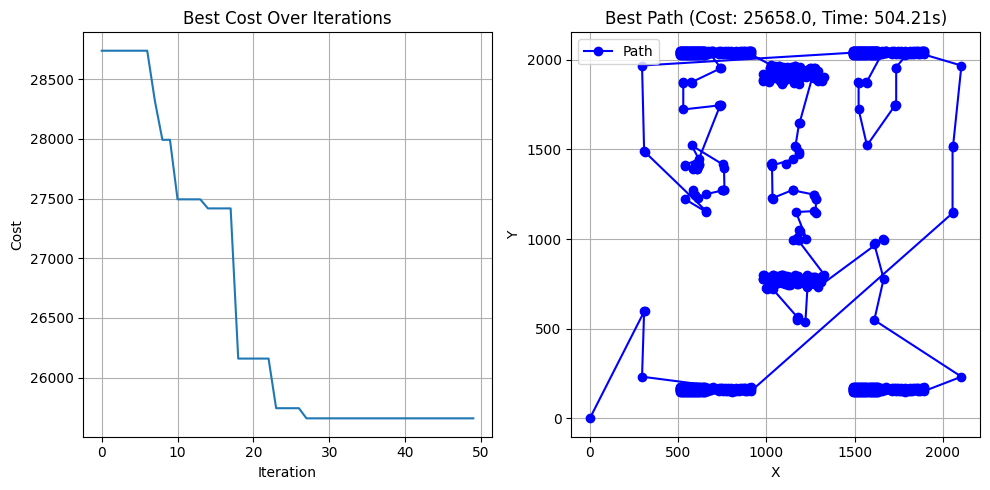

Testing alpha=1.5, beta=2.0, rho=0.5
Iteration 1/50 - Best Cost: 65844.0
Iteration 2/50 - Best Cost: 65844.0
Iteration 3/50 - Best Cost: 65844.0
Iteration 4/50 - Best Cost: 65259.0
Iteration 5/50 - Best Cost: 63256.0
Iteration 6/50 - Best Cost: 63256.0
Iteration 7/50 - Best Cost: 63256.0
Iteration 8/50 - Best Cost: 63256.0
Iteration 9/50 - Best Cost: 63256.0
Iteration 10/50 - Best Cost: 63256.0
Iteration 11/50 - Best Cost: 63256.0
Iteration 12/50 - Best Cost: 63256.0
Iteration 13/50 - Best Cost: 63256.0
Iteration 14/50 - Best Cost: 61143.0
Iteration 15/50 - Best Cost: 54635.0
Iteration 16/50 - Best Cost: 51714.0
Iteration 17/50 - Best Cost: 49017.0
Iteration 18/50 - Best Cost: 41847.0
Iteration 19/50 - Best Cost: 39803.0
Iteration 20/50 - Best Cost: 35119.0
Iteration 21/50 - Best Cost: 33628.0
Iteration 22/50 - Best Cost: 33628.0
Iteration 23/50 - Best Cost: 33565.0
Iteration 24/50 - Best Cost: 33565.0
Iteration 25/50 - Best Cost: 33348.0
Iteration 26/50 - Best Cost: 33007.0
Iteration 

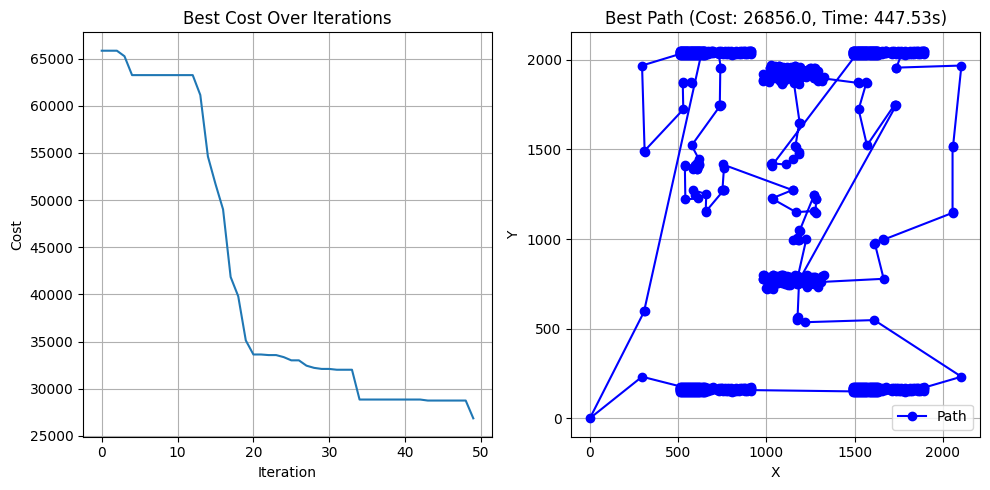

Testing alpha=1.5, beta=2.0, rho=0.1
Iteration 1/50 - Best Cost: 66847.0
Iteration 2/50 - Best Cost: 64388.0
Iteration 3/50 - Best Cost: 64388.0
Iteration 4/50 - Best Cost: 64388.0
Iteration 5/50 - Best Cost: 64388.0
Iteration 6/50 - Best Cost: 64388.0
Iteration 7/50 - Best Cost: 64388.0
Iteration 8/50 - Best Cost: 64388.0
Iteration 9/50 - Best Cost: 64388.0
Iteration 10/50 - Best Cost: 64388.0
Iteration 11/50 - Best Cost: 64388.0
Iteration 12/50 - Best Cost: 64307.0
Iteration 13/50 - Best Cost: 64307.0
Iteration 14/50 - Best Cost: 64307.0
Iteration 15/50 - Best Cost: 64307.0
Iteration 16/50 - Best Cost: 64307.0
Iteration 17/50 - Best Cost: 64307.0
Iteration 18/50 - Best Cost: 64307.0
Iteration 19/50 - Best Cost: 64307.0
Iteration 20/50 - Best Cost: 64307.0
Iteration 21/50 - Best Cost: 64307.0
Iteration 22/50 - Best Cost: 64307.0
Iteration 23/50 - Best Cost: 63972.0
Iteration 24/50 - Best Cost: 63972.0
Iteration 25/50 - Best Cost: 63972.0
Iteration 26/50 - Best Cost: 63972.0
Iteration 

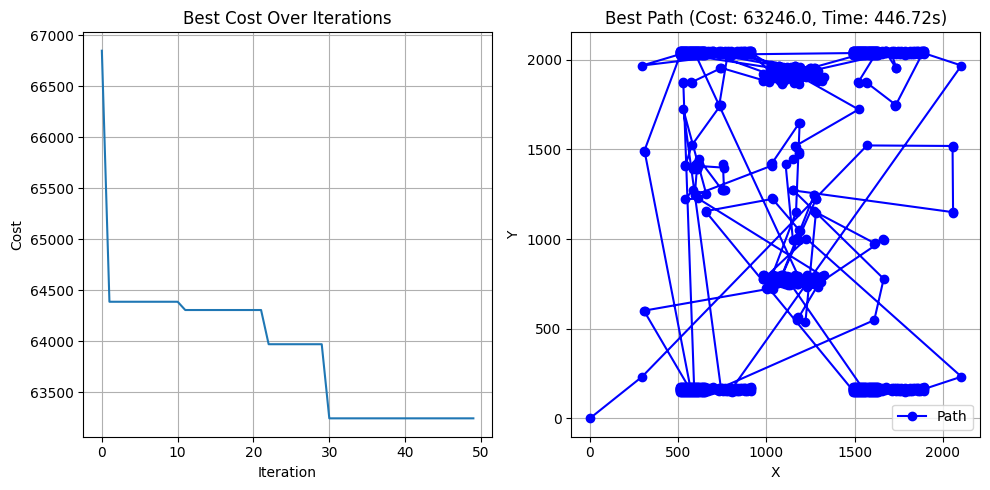

Testing alpha=1.5, beta=2.0, rho=0.9
Iteration 1/50 - Best Cost: 71340.0
Iteration 2/50 - Best Cost: 63190.0
Iteration 3/50 - Best Cost: 63190.0
Iteration 4/50 - Best Cost: 63190.0
Iteration 5/50 - Best Cost: 60718.0
Iteration 6/50 - Best Cost: 44830.0
Iteration 7/50 - Best Cost: 40667.0
Iteration 8/50 - Best Cost: 36817.0
Iteration 9/50 - Best Cost: 36817.0
Iteration 10/50 - Best Cost: 36817.0
Iteration 11/50 - Best Cost: 36817.0
Iteration 12/50 - Best Cost: 36817.0
Iteration 13/50 - Best Cost: 36817.0
Iteration 14/50 - Best Cost: 36817.0
Iteration 15/50 - Best Cost: 36817.0
Iteration 16/50 - Best Cost: 36817.0
Iteration 17/50 - Best Cost: 36817.0
Iteration 18/50 - Best Cost: 33665.0
Iteration 19/50 - Best Cost: 33665.0
Iteration 20/50 - Best Cost: 33665.0
Iteration 21/50 - Best Cost: 33665.0
Iteration 22/50 - Best Cost: 33665.0
Iteration 23/50 - Best Cost: 30805.0
Iteration 24/50 - Best Cost: 30805.0
Iteration 25/50 - Best Cost: 30805.0
Iteration 26/50 - Best Cost: 30805.0
Iteration 

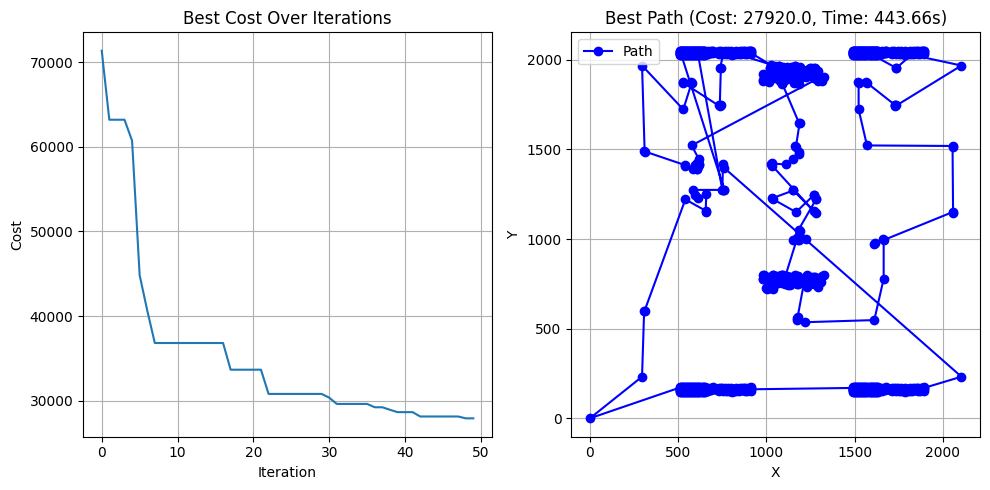

Testing alpha=1.5, beta=50, rho=0.5
Iteration 1/50 - Best Cost: 24118.0
Iteration 2/50 - Best Cost: 23814.0
Iteration 3/50 - Best Cost: 23814.0
Iteration 4/50 - Best Cost: 23814.0
Iteration 5/50 - Best Cost: 23814.0
Iteration 6/50 - Best Cost: 23814.0
Iteration 7/50 - Best Cost: 23814.0
Iteration 8/50 - Best Cost: 23814.0
Iteration 9/50 - Best Cost: 23814.0
Iteration 10/50 - Best Cost: 23814.0
Iteration 11/50 - Best Cost: 22764.0
Iteration 12/50 - Best Cost: 22764.0
Iteration 13/50 - Best Cost: 22764.0
Iteration 14/50 - Best Cost: 22764.0
Iteration 15/50 - Best Cost: 22324.0
Iteration 16/50 - Best Cost: 22324.0
Iteration 17/50 - Best Cost: 22258.0
Iteration 18/50 - Best Cost: 22258.0
Iteration 19/50 - Best Cost: 22258.0
Iteration 20/50 - Best Cost: 22258.0
Iteration 21/50 - Best Cost: 22258.0
Iteration 22/50 - Best Cost: 22258.0
Iteration 23/50 - Best Cost: 22176.0
Iteration 24/50 - Best Cost: 22176.0
Iteration 25/50 - Best Cost: 22176.0
Iteration 26/50 - Best Cost: 22176.0
Iteration 2

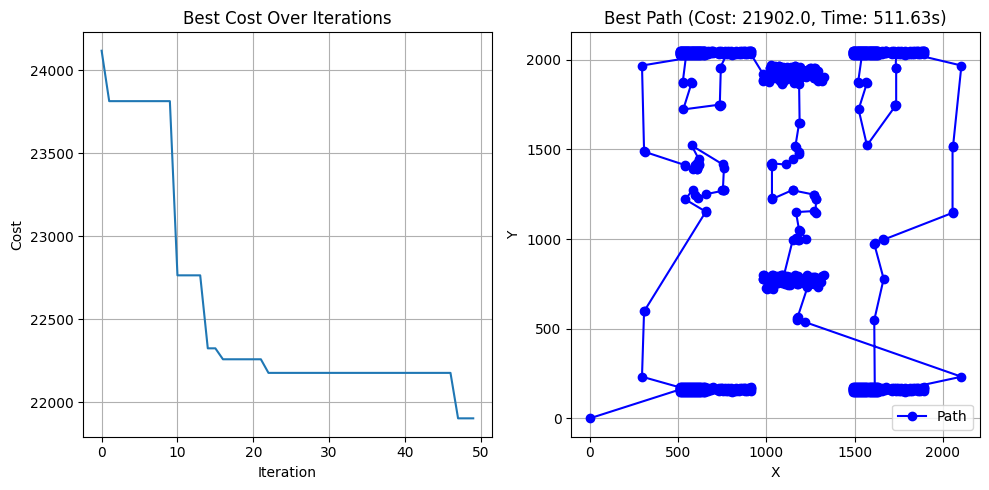

Testing alpha=1.5, beta=50, rho=0.1
Iteration 1/50 - Best Cost: 23665.0
Iteration 2/50 - Best Cost: 23495.0
Iteration 3/50 - Best Cost: 23495.0
Iteration 4/50 - Best Cost: 23495.0
Iteration 5/50 - Best Cost: 23495.0
Iteration 6/50 - Best Cost: 23495.0
Iteration 7/50 - Best Cost: 23495.0
Iteration 8/50 - Best Cost: 23495.0
Iteration 9/50 - Best Cost: 23495.0
Iteration 10/50 - Best Cost: 23495.0
Iteration 11/50 - Best Cost: 23495.0
Iteration 12/50 - Best Cost: 23495.0
Iteration 13/50 - Best Cost: 23495.0
Iteration 14/50 - Best Cost: 23495.0
Iteration 15/50 - Best Cost: 23495.0
Iteration 16/50 - Best Cost: 23495.0
Iteration 17/50 - Best Cost: 23286.0
Iteration 18/50 - Best Cost: 23286.0
Iteration 19/50 - Best Cost: 23286.0
Iteration 20/50 - Best Cost: 23286.0
Iteration 21/50 - Best Cost: 23286.0
Iteration 22/50 - Best Cost: 23286.0
Iteration 23/50 - Best Cost: 23286.0
Iteration 24/50 - Best Cost: 23286.0
Iteration 25/50 - Best Cost: 23286.0
Iteration 26/50 - Best Cost: 23286.0
Iteration 2

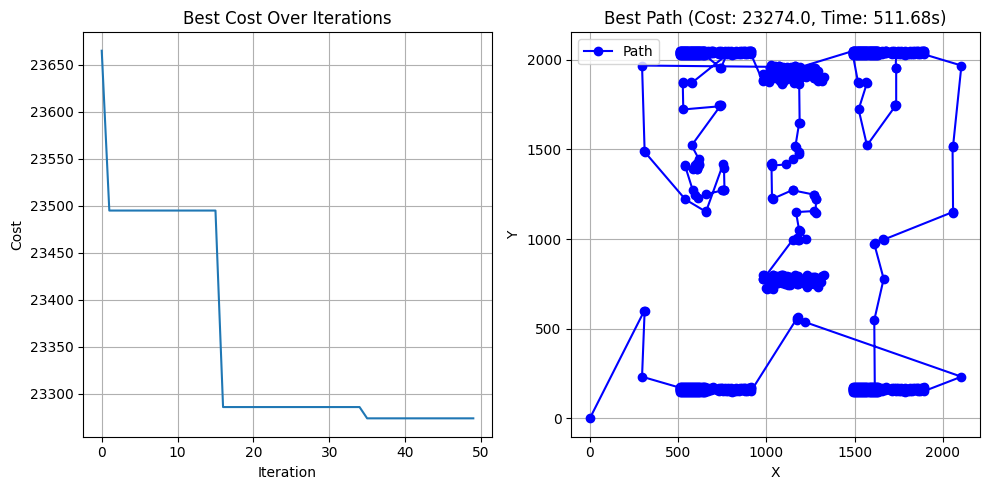

Testing alpha=1.5, beta=50, rho=0.9
Iteration 1/50 - Best Cost: 23726.0
Iteration 2/50 - Best Cost: 23726.0
Iteration 3/50 - Best Cost: 23726.0
Iteration 4/50 - Best Cost: 23726.0
Iteration 5/50 - Best Cost: 23726.0
Iteration 6/50 - Best Cost: 23726.0
Iteration 7/50 - Best Cost: 23182.0
Iteration 8/50 - Best Cost: 23033.0
Iteration 9/50 - Best Cost: 23033.0
Iteration 10/50 - Best Cost: 23033.0
Iteration 11/50 - Best Cost: 23033.0
Iteration 12/50 - Best Cost: 23033.0
Iteration 13/50 - Best Cost: 23033.0
Iteration 14/50 - Best Cost: 23033.0
Iteration 15/50 - Best Cost: 23033.0
Iteration 16/50 - Best Cost: 23033.0
Iteration 17/50 - Best Cost: 23033.0
Iteration 18/50 - Best Cost: 23033.0
Iteration 19/50 - Best Cost: 23033.0
Iteration 20/50 - Best Cost: 23033.0
Iteration 21/50 - Best Cost: 23033.0
Iteration 22/50 - Best Cost: 23033.0
Iteration 23/50 - Best Cost: 23033.0
Iteration 24/50 - Best Cost: 23033.0
Iteration 25/50 - Best Cost: 23033.0
Iteration 26/50 - Best Cost: 23033.0
Iteration 2

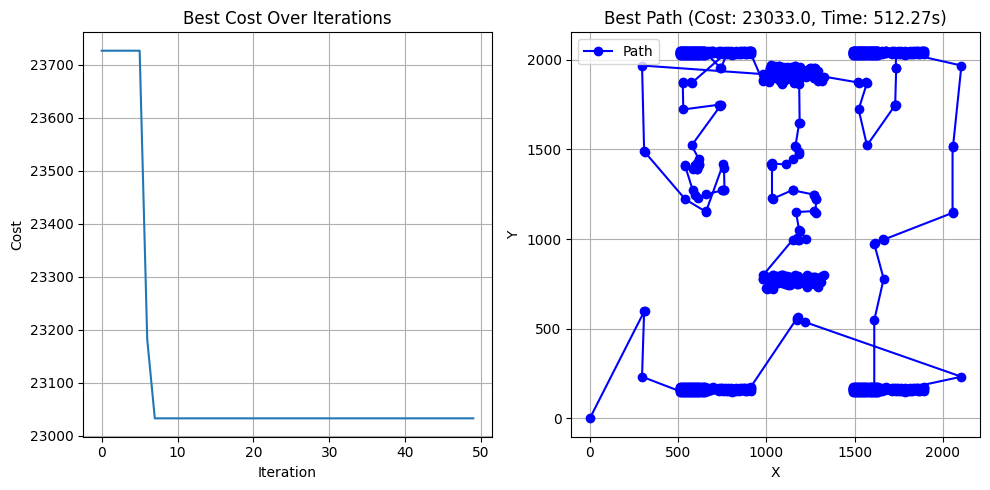

Testing alpha=1.5, beta=5.0, rho=0.5
Iteration 1/50 - Best Cost: 29730.0
Iteration 2/50 - Best Cost: 29730.0
Iteration 3/50 - Best Cost: 29730.0
Iteration 4/50 - Best Cost: 29730.0
Iteration 5/50 - Best Cost: 29668.0
Iteration 6/50 - Best Cost: 29668.0
Iteration 7/50 - Best Cost: 29668.0
Iteration 8/50 - Best Cost: 29668.0
Iteration 9/50 - Best Cost: 28705.0
Iteration 10/50 - Best Cost: 28705.0
Iteration 11/50 - Best Cost: 28705.0
Iteration 12/50 - Best Cost: 27630.0
Iteration 13/50 - Best Cost: 27630.0
Iteration 14/50 - Best Cost: 27373.0
Iteration 15/50 - Best Cost: 27053.0
Iteration 16/50 - Best Cost: 25908.0
Iteration 17/50 - Best Cost: 25712.0
Iteration 18/50 - Best Cost: 25200.0
Iteration 19/50 - Best Cost: 25200.0
Iteration 20/50 - Best Cost: 24905.0
Iteration 21/50 - Best Cost: 24534.0
Iteration 22/50 - Best Cost: 24534.0
Iteration 23/50 - Best Cost: 24534.0
Iteration 24/50 - Best Cost: 24534.0
Iteration 25/50 - Best Cost: 24534.0
Iteration 26/50 - Best Cost: 24534.0
Iteration 

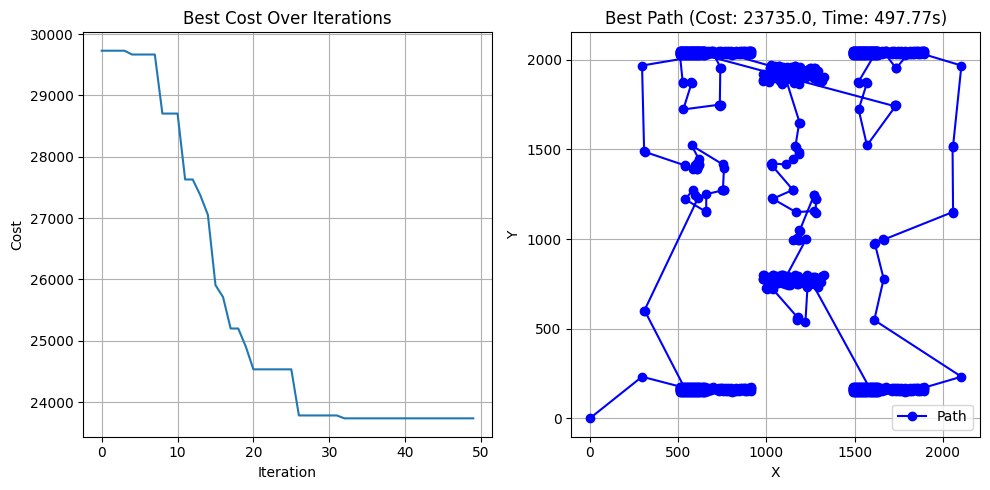

Testing alpha=1.5, beta=5.0, rho=0.1
Iteration 1/50 - Best Cost: 31156.0
Iteration 2/50 - Best Cost: 29403.0
Iteration 3/50 - Best Cost: 29403.0
Iteration 4/50 - Best Cost: 29270.0
Iteration 5/50 - Best Cost: 29270.0
Iteration 6/50 - Best Cost: 29270.0
Iteration 7/50 - Best Cost: 29270.0
Iteration 8/50 - Best Cost: 29270.0
Iteration 9/50 - Best Cost: 29270.0
Iteration 10/50 - Best Cost: 29270.0
Iteration 11/50 - Best Cost: 29270.0
Iteration 12/50 - Best Cost: 29270.0
Iteration 13/50 - Best Cost: 29270.0
Iteration 14/50 - Best Cost: 29270.0
Iteration 15/50 - Best Cost: 29270.0
Iteration 16/50 - Best Cost: 29270.0
Iteration 17/50 - Best Cost: 29270.0
Iteration 18/50 - Best Cost: 28989.0
Iteration 19/50 - Best Cost: 28989.0
Iteration 20/50 - Best Cost: 28989.0
Iteration 21/50 - Best Cost: 28989.0
Iteration 22/50 - Best Cost: 28989.0
Iteration 23/50 - Best Cost: 28989.0
Iteration 24/50 - Best Cost: 28200.0
Iteration 25/50 - Best Cost: 28200.0
Iteration 26/50 - Best Cost: 28200.0
Iteration 

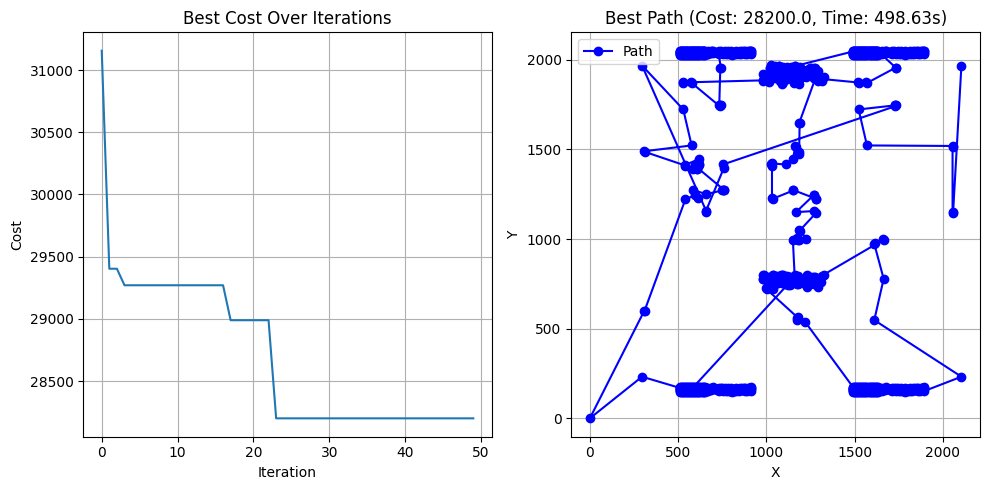

Testing alpha=1.5, beta=5.0, rho=0.9
Iteration 1/50 - Best Cost: 30230.0
Iteration 2/50 - Best Cost: 30230.0
Iteration 3/50 - Best Cost: 28560.0
Iteration 4/50 - Best Cost: 28560.0
Iteration 5/50 - Best Cost: 28560.0
Iteration 6/50 - Best Cost: 26431.0
Iteration 7/50 - Best Cost: 25686.0
Iteration 8/50 - Best Cost: 24974.0
Iteration 9/50 - Best Cost: 24974.0
Iteration 10/50 - Best Cost: 24974.0
Iteration 11/50 - Best Cost: 24974.0
Iteration 12/50 - Best Cost: 24974.0
Iteration 13/50 - Best Cost: 24974.0
Iteration 14/50 - Best Cost: 24974.0
Iteration 15/50 - Best Cost: 24974.0
Iteration 16/50 - Best Cost: 24974.0
Iteration 17/50 - Best Cost: 24974.0
Iteration 18/50 - Best Cost: 24974.0
Iteration 19/50 - Best Cost: 24974.0
Iteration 20/50 - Best Cost: 24974.0
Iteration 21/50 - Best Cost: 24974.0
Iteration 22/50 - Best Cost: 24974.0
Iteration 23/50 - Best Cost: 24974.0
Iteration 24/50 - Best Cost: 24974.0
Iteration 25/50 - Best Cost: 24974.0
Iteration 26/50 - Best Cost: 24974.0
Iteration 

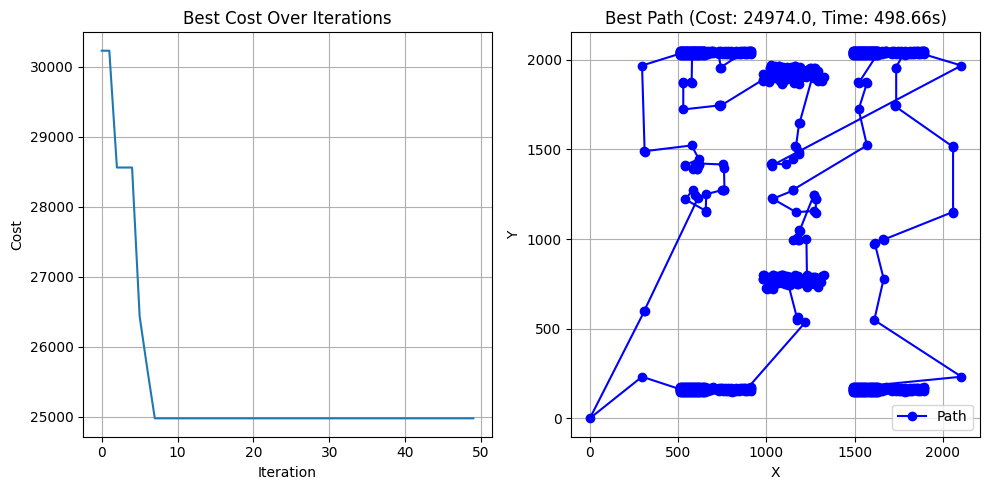

Testing alpha=2.0, beta=2.0, rho=0.5
Iteration 1/50 - Best Cost: 68188.0
Iteration 2/50 - Best Cost: 66574.0
Iteration 3/50 - Best Cost: 66574.0
Iteration 4/50 - Best Cost: 65797.0
Iteration 5/50 - Best Cost: 65797.0
Iteration 6/50 - Best Cost: 65797.0
Iteration 7/50 - Best Cost: 65797.0
Iteration 8/50 - Best Cost: 65797.0
Iteration 9/50 - Best Cost: 65797.0
Iteration 10/50 - Best Cost: 64645.0
Iteration 11/50 - Best Cost: 64645.0
Iteration 12/50 - Best Cost: 63525.0
Iteration 13/50 - Best Cost: 61005.0
Iteration 14/50 - Best Cost: 60101.0
Iteration 15/50 - Best Cost: 53387.0
Iteration 16/50 - Best Cost: 45781.0
Iteration 17/50 - Best Cost: 41699.0
Iteration 18/50 - Best Cost: 38040.0
Iteration 19/50 - Best Cost: 34168.0
Iteration 20/50 - Best Cost: 30750.0
Iteration 21/50 - Best Cost: 30750.0
Iteration 22/50 - Best Cost: 30750.0
Iteration 23/50 - Best Cost: 30750.0
Iteration 24/50 - Best Cost: 30750.0
Iteration 25/50 - Best Cost: 30750.0
Iteration 26/50 - Best Cost: 30750.0
Iteration 

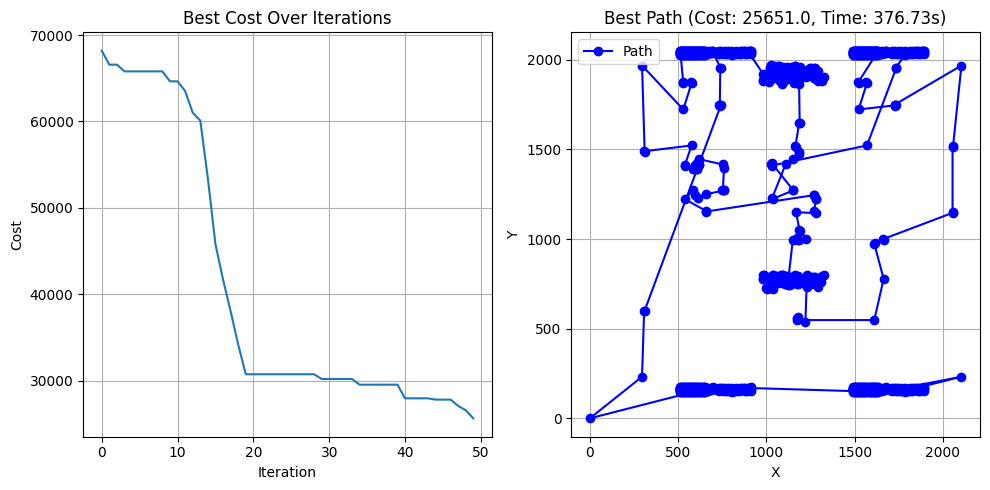

Testing alpha=2.0, beta=2.0, rho=0.1
Iteration 1/50 - Best Cost: 65779.0
Iteration 2/50 - Best Cost: 65779.0
Iteration 3/50 - Best Cost: 63904.0
Iteration 4/50 - Best Cost: 63904.0
Iteration 5/50 - Best Cost: 63904.0
Iteration 6/50 - Best Cost: 63904.0
Iteration 7/50 - Best Cost: 63904.0
Iteration 8/50 - Best Cost: 63904.0
Iteration 9/50 - Best Cost: 62467.0
Iteration 10/50 - Best Cost: 62467.0
Iteration 11/50 - Best Cost: 62467.0
Iteration 12/50 - Best Cost: 62467.0
Iteration 13/50 - Best Cost: 62467.0
Iteration 14/50 - Best Cost: 62467.0
Iteration 15/50 - Best Cost: 62467.0
Iteration 16/50 - Best Cost: 62467.0
Iteration 17/50 - Best Cost: 62467.0
Iteration 18/50 - Best Cost: 62467.0
Iteration 19/50 - Best Cost: 62467.0
Iteration 20/50 - Best Cost: 62467.0
Iteration 21/50 - Best Cost: 62467.0
Iteration 22/50 - Best Cost: 62467.0
Iteration 23/50 - Best Cost: 62467.0
Iteration 24/50 - Best Cost: 62467.0
Iteration 25/50 - Best Cost: 62467.0
Iteration 26/50 - Best Cost: 62467.0
Iteration 

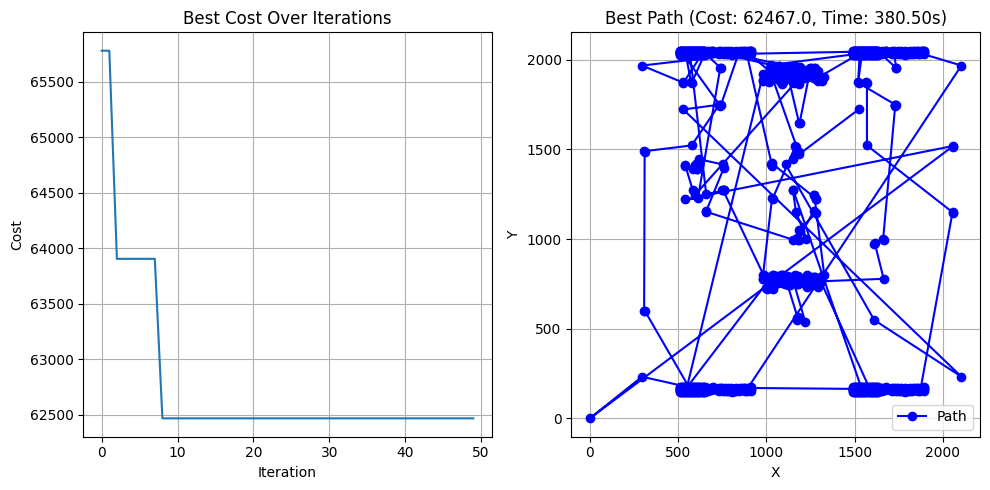

Testing alpha=2.0, beta=2.0, rho=0.9
Iteration 1/50 - Best Cost: 69225.0
Iteration 2/50 - Best Cost: 66040.0
Iteration 3/50 - Best Cost: 66040.0
Iteration 4/50 - Best Cost: 64588.0
Iteration 5/50 - Best Cost: 63965.0
Iteration 6/50 - Best Cost: 44014.0
Iteration 7/50 - Best Cost: 38846.0
Iteration 8/50 - Best Cost: 37787.0
Iteration 9/50 - Best Cost: 37354.0
Iteration 10/50 - Best Cost: 35447.0
Iteration 11/50 - Best Cost: 35447.0
Iteration 12/50 - Best Cost: 35447.0
Iteration 13/50 - Best Cost: 33887.0
Iteration 14/50 - Best Cost: 33887.0
Iteration 15/50 - Best Cost: 33887.0
Iteration 16/50 - Best Cost: 33887.0
Iteration 17/50 - Best Cost: 33887.0
Iteration 18/50 - Best Cost: 32339.0
Iteration 19/50 - Best Cost: 32339.0
Iteration 20/50 - Best Cost: 32339.0
Iteration 21/50 - Best Cost: 32339.0
Iteration 22/50 - Best Cost: 31164.0
Iteration 23/50 - Best Cost: 29283.0
Iteration 24/50 - Best Cost: 29283.0
Iteration 25/50 - Best Cost: 29283.0
Iteration 26/50 - Best Cost: 29283.0
Iteration 

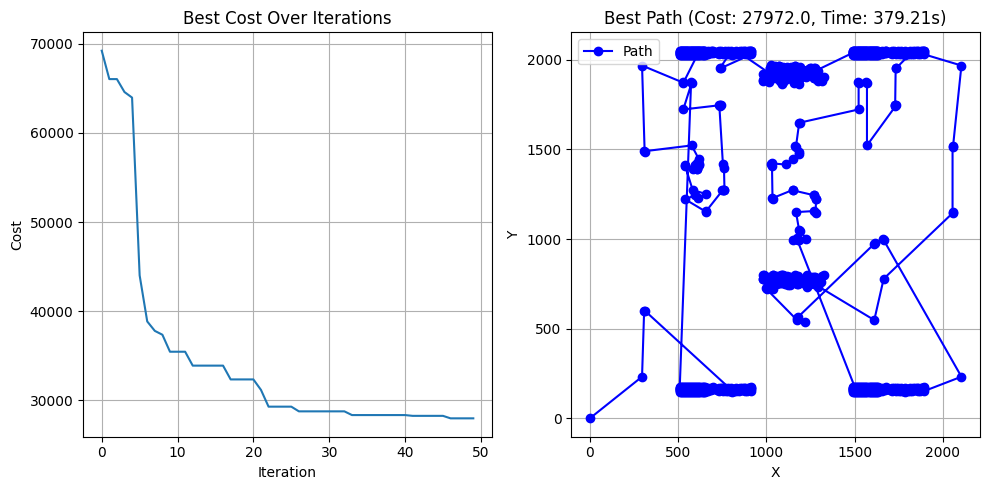

Testing alpha=2.0, beta=50, rho=0.5
Iteration 1/50 - Best Cost: 24213.0
Iteration 2/50 - Best Cost: 23780.0
Iteration 3/50 - Best Cost: 23780.0
Iteration 4/50 - Best Cost: 23780.0
Iteration 5/50 - Best Cost: 23780.0
Iteration 6/50 - Best Cost: 23780.0
Iteration 7/50 - Best Cost: 23780.0
Iteration 8/50 - Best Cost: 23780.0
Iteration 9/50 - Best Cost: 23780.0
Iteration 10/50 - Best Cost: 23780.0
Iteration 11/50 - Best Cost: 23701.0
Iteration 12/50 - Best Cost: 23701.0
Iteration 13/50 - Best Cost: 23336.0
Iteration 14/50 - Best Cost: 23336.0
Iteration 15/50 - Best Cost: 23336.0
Iteration 16/50 - Best Cost: 22851.0
Iteration 17/50 - Best Cost: 22169.0
Iteration 18/50 - Best Cost: 22169.0
Iteration 19/50 - Best Cost: 22169.0
Iteration 20/50 - Best Cost: 22080.0
Iteration 21/50 - Best Cost: 22080.0
Iteration 22/50 - Best Cost: 22080.0
Iteration 23/50 - Best Cost: 22080.0
Iteration 24/50 - Best Cost: 22080.0
Iteration 25/50 - Best Cost: 22080.0
Iteration 26/50 - Best Cost: 22080.0
Iteration 2

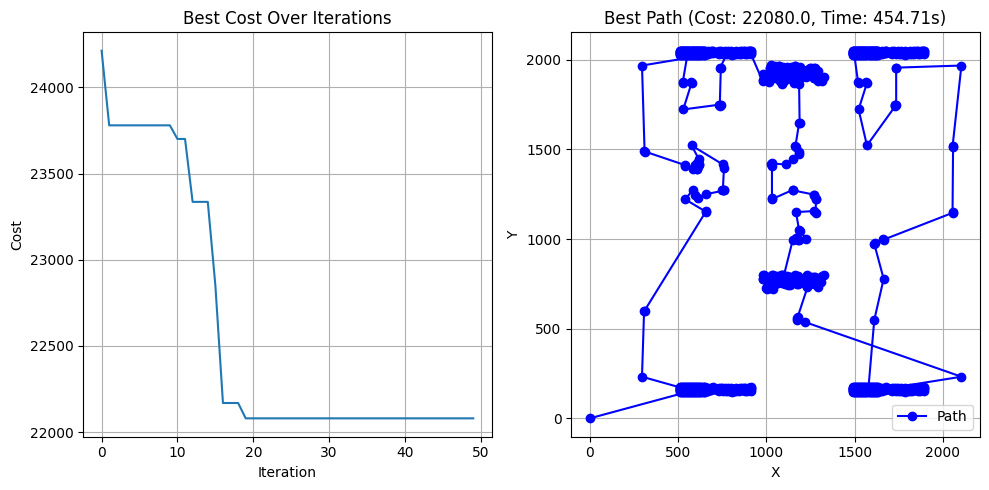

Testing alpha=2.0, beta=50, rho=0.1
Iteration 1/50 - Best Cost: 23790.0
Iteration 2/50 - Best Cost: 23790.0
Iteration 3/50 - Best Cost: 23790.0
Iteration 4/50 - Best Cost: 23790.0
Iteration 5/50 - Best Cost: 23790.0
Iteration 6/50 - Best Cost: 23790.0
Iteration 7/50 - Best Cost: 23790.0
Iteration 8/50 - Best Cost: 23790.0
Iteration 9/50 - Best Cost: 23790.0
Iteration 10/50 - Best Cost: 23790.0
Iteration 11/50 - Best Cost: 23790.0
Iteration 12/50 - Best Cost: 23790.0
Iteration 13/50 - Best Cost: 23790.0
Iteration 14/50 - Best Cost: 23790.0
Iteration 15/50 - Best Cost: 23790.0
Iteration 16/50 - Best Cost: 23790.0
Iteration 17/50 - Best Cost: 23790.0
Iteration 18/50 - Best Cost: 23790.0
Iteration 19/50 - Best Cost: 23790.0
Iteration 20/50 - Best Cost: 23790.0
Iteration 21/50 - Best Cost: 23790.0
Iteration 22/50 - Best Cost: 23790.0
Iteration 23/50 - Best Cost: 23790.0
Iteration 24/50 - Best Cost: 23790.0
Iteration 25/50 - Best Cost: 23790.0
Iteration 26/50 - Best Cost: 23790.0
Iteration 2

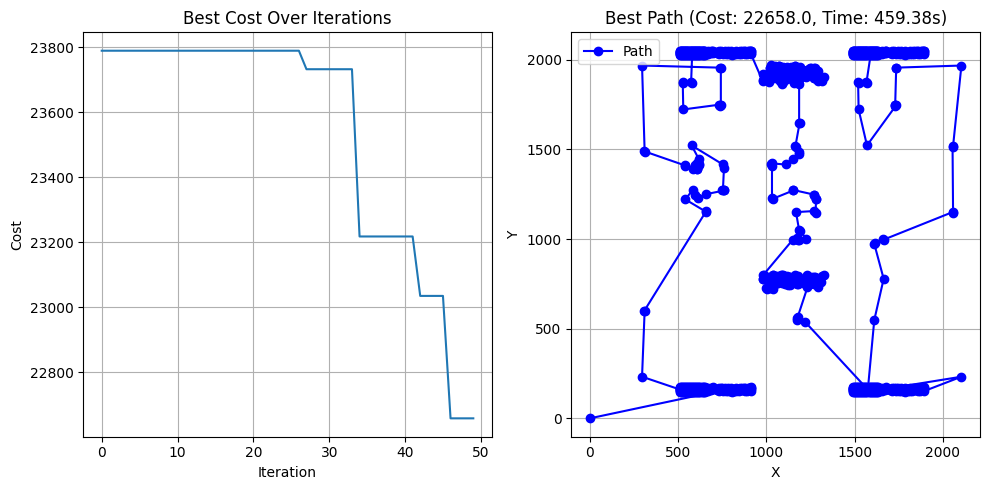

Testing alpha=2.0, beta=50, rho=0.9
Iteration 1/50 - Best Cost: 24246.0
Iteration 2/50 - Best Cost: 24246.0
Iteration 3/50 - Best Cost: 24086.0
Iteration 4/50 - Best Cost: 24086.0
Iteration 5/50 - Best Cost: 23307.0
Iteration 6/50 - Best Cost: 23307.0
Iteration 7/50 - Best Cost: 23084.0
Iteration 8/50 - Best Cost: 23084.0
Iteration 9/50 - Best Cost: 23084.0
Iteration 10/50 - Best Cost: 22477.0
Iteration 11/50 - Best Cost: 22477.0
Iteration 12/50 - Best Cost: 22477.0
Iteration 13/50 - Best Cost: 22477.0
Iteration 14/50 - Best Cost: 22443.0
Iteration 15/50 - Best Cost: 22389.0
Iteration 16/50 - Best Cost: 22389.0
Iteration 17/50 - Best Cost: 22389.0
Iteration 18/50 - Best Cost: 22389.0
Iteration 19/50 - Best Cost: 22389.0
Iteration 20/50 - Best Cost: 22389.0
Iteration 21/50 - Best Cost: 22389.0
Iteration 22/50 - Best Cost: 22389.0
Iteration 23/50 - Best Cost: 22389.0
Iteration 24/50 - Best Cost: 22389.0
Iteration 25/50 - Best Cost: 22389.0
Iteration 26/50 - Best Cost: 22389.0
Iteration 2

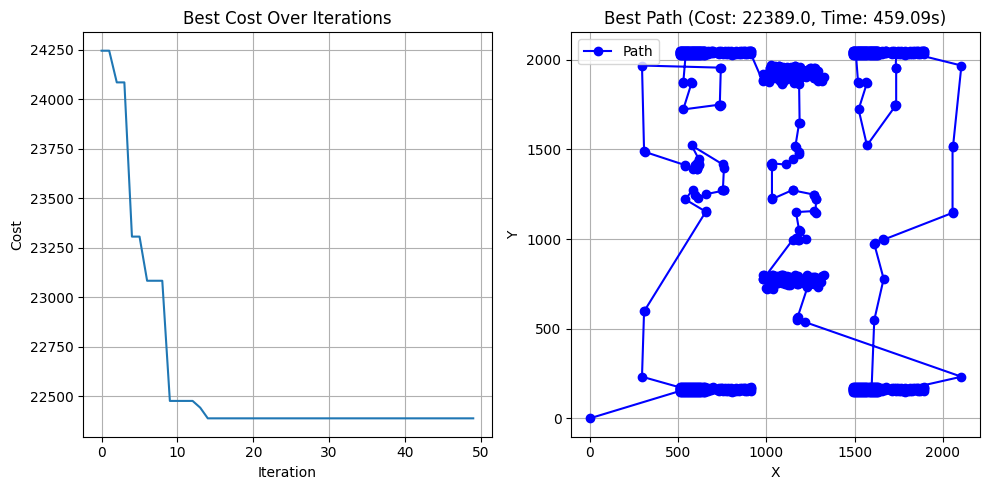

Testing alpha=2.0, beta=5.0, rho=0.5
Iteration 1/50 - Best Cost: 29821.0
Iteration 2/50 - Best Cost: 29658.0
Iteration 3/50 - Best Cost: 29564.0
Iteration 4/50 - Best Cost: 29564.0
Iteration 5/50 - Best Cost: 29564.0
Iteration 6/50 - Best Cost: 29564.0
Iteration 7/50 - Best Cost: 29564.0
Iteration 8/50 - Best Cost: 29564.0
Iteration 9/50 - Best Cost: 28920.0
Iteration 10/50 - Best Cost: 28827.0
Iteration 11/50 - Best Cost: 28337.0
Iteration 12/50 - Best Cost: 28337.0
Iteration 13/50 - Best Cost: 27551.0
Iteration 14/50 - Best Cost: 27551.0
Iteration 15/50 - Best Cost: 27405.0
Iteration 16/50 - Best Cost: 26542.0
Iteration 17/50 - Best Cost: 25054.0
Iteration 18/50 - Best Cost: 22126.0
Iteration 19/50 - Best Cost: 22126.0
Iteration 20/50 - Best Cost: 22126.0
Iteration 21/50 - Best Cost: 22126.0
Iteration 22/50 - Best Cost: 22126.0
Iteration 23/50 - Best Cost: 22126.0
Iteration 24/50 - Best Cost: 22126.0
Iteration 25/50 - Best Cost: 22126.0
Iteration 26/50 - Best Cost: 22126.0
Iteration 

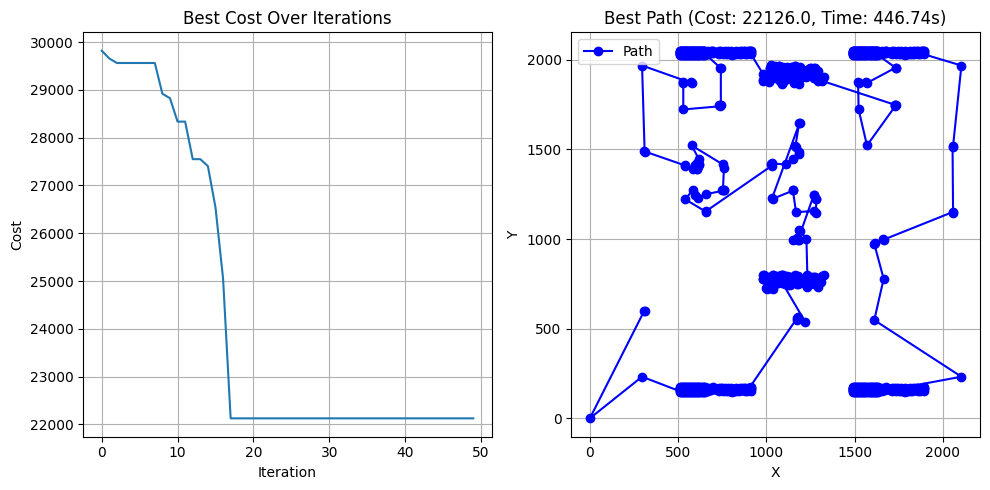

Testing alpha=2.0, beta=5.0, rho=0.1
Iteration 1/50 - Best Cost: 29722.0
Iteration 2/50 - Best Cost: 29722.0
Iteration 3/50 - Best Cost: 29722.0
Iteration 4/50 - Best Cost: 29438.0
Iteration 5/50 - Best Cost: 29438.0
Iteration 6/50 - Best Cost: 29438.0
Iteration 7/50 - Best Cost: 29438.0
Iteration 8/50 - Best Cost: 29438.0
Iteration 9/50 - Best Cost: 28285.0
Iteration 10/50 - Best Cost: 28285.0
Iteration 11/50 - Best Cost: 28285.0
Iteration 12/50 - Best Cost: 28285.0
Iteration 13/50 - Best Cost: 28285.0
Iteration 14/50 - Best Cost: 28285.0
Iteration 15/50 - Best Cost: 28285.0
Iteration 16/50 - Best Cost: 28285.0
Iteration 17/50 - Best Cost: 28285.0
Iteration 18/50 - Best Cost: 28285.0
Iteration 19/50 - Best Cost: 28285.0
Iteration 20/50 - Best Cost: 28285.0
Iteration 21/50 - Best Cost: 28285.0
Iteration 22/50 - Best Cost: 28285.0
Iteration 23/50 - Best Cost: 28285.0
Iteration 24/50 - Best Cost: 28285.0
Iteration 25/50 - Best Cost: 28285.0
Iteration 26/50 - Best Cost: 28285.0
Iteration 

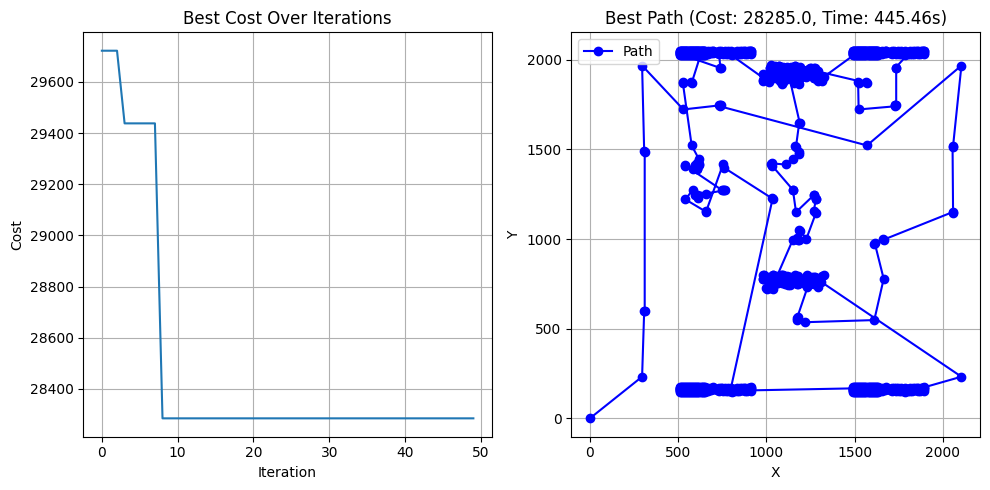

Testing alpha=2.0, beta=5.0, rho=0.9
Iteration 1/50 - Best Cost: 30227.0
Iteration 2/50 - Best Cost: 29557.0
Iteration 3/50 - Best Cost: 29557.0
Iteration 4/50 - Best Cost: 29297.0
Iteration 5/50 - Best Cost: 28038.0
Iteration 6/50 - Best Cost: 26080.0
Iteration 7/50 - Best Cost: 25505.0
Iteration 8/50 - Best Cost: 25505.0
Iteration 9/50 - Best Cost: 25505.0
Iteration 10/50 - Best Cost: 25505.0
Iteration 11/50 - Best Cost: 25505.0
Iteration 12/50 - Best Cost: 25505.0
Iteration 13/50 - Best Cost: 25505.0
Iteration 14/50 - Best Cost: 25505.0
Iteration 15/50 - Best Cost: 25505.0
Iteration 16/50 - Best Cost: 25505.0
Iteration 17/50 - Best Cost: 25505.0
Iteration 18/50 - Best Cost: 25505.0
Iteration 19/50 - Best Cost: 25505.0
Iteration 20/50 - Best Cost: 25505.0
Iteration 21/50 - Best Cost: 25505.0
Iteration 22/50 - Best Cost: 25505.0
Iteration 23/50 - Best Cost: 25505.0
Iteration 24/50 - Best Cost: 25505.0
Iteration 25/50 - Best Cost: 25505.0
Iteration 26/50 - Best Cost: 25505.0
Iteration 

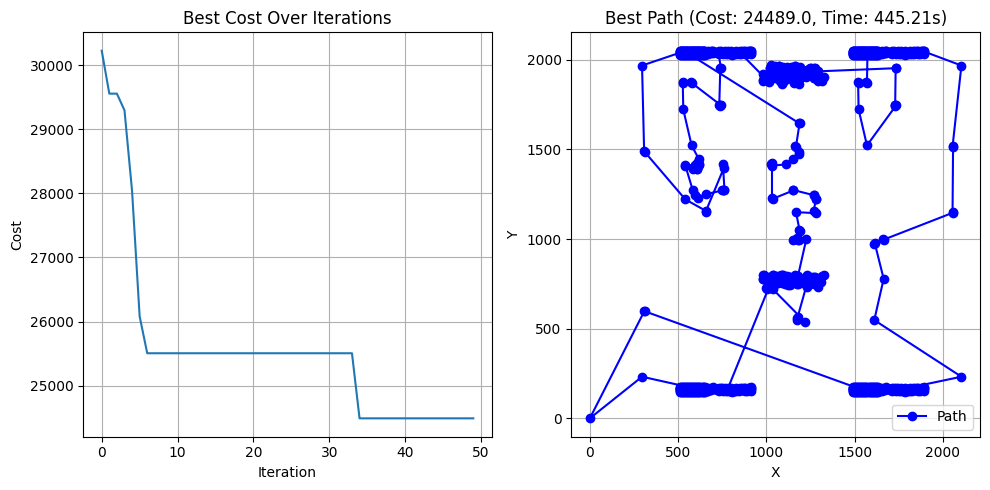

Best parameters: alpha=1.5, beta=50, rho=0.5
Best overall cost: 21902.0
Best overall solution: [1323, 1315, 1378, 1188, 1372, 1304, 1189, 1330, 297, 469, 395, 421, 335, 493, 359, 444, 334, 468, 296, 394, 420, 295, 358, 492, 298, 422, 396, 470, 299, 423, 337, 495, 362, 446, 302, 472, 365, 497, 339, 425, 399, 447, 303, 473, 366, 449, 401, 475, 369, 451, 341, 427, 305, 448, 400, 474, 368, 499, 403, 429, 308, 450, 340, 498, 307, 428, 342, 476, 402, 367, 426, 304, 496, 364, 424, 398, 494, 361, 301, 338, 336, 397, 445, 360, 300, 471, 363, 306, 309, 477, 343, 501, 311, 452, 404, 478, 344, 454, 374, 431, 345, 503, 407, 433, 347, 457, 378, 481, 315, 455, 375, 479, 312, 453, 372, 405, 371, 500, 370, 310, 430, 373, 502, 313, 432, 376, 504, 316, 434, 379, 506, 348, 458, 410, 484, 350, 460, 323, 509, 383, 437, 411, 507, 349, 435, 409, 505, 317, 482, 408, 456, 377, 480, 346, 406, 314, 318, 483, 381, 459, 321, 485, 384, 461, 324, 487, 413, 439, 353, 463, 387, 327, 489, 415, 511, 326, 441, 355, 465, 3

In [ ]:
import time  # Import the time module for time tracking
import numpy as np
import matplotlib.pyplot as plt

def parameter_tuning(distance_matrix, coords, num_ants, max_iter, alpha_values, beta_values, rho_values):
    best_overall_cost = float('inf')
    best_overall_params = None
    best_overall_solution = None
    results = []

    for i, alpha in enumerate(alpha_values):
        for j, beta in enumerate(beta_values):
            for k, rho in enumerate(rho_values):
                print(f"Testing alpha={alpha}, beta={beta}, rho={rho}")

                # Start timing the execution of the algorithm for this parameter set
                start_time = time.time()

                # Run the ACO algorithm
                aco = AntColonyOptimization(distance_matrix, num_ants=num_ants, max_iter=max_iter, alpha=alpha, beta=beta, rho=rho)
                best_solution, best_cost = aco.run()

                # End timing
                end_time = time.time()
                elapsed_time = end_time - start_time

                # Store the results including the time taken
                results.append({
                    'alpha': alpha,
                    'beta': beta,
                    'rho': rho,
                    'best_cost': best_cost,
                    'best_solution': best_solution,
                    'time': elapsed_time  # Add the elapsed time
                })

                if best_cost < best_overall_cost:
                    best_overall_cost = best_cost
                    best_overall_params = (alpha, beta, rho)
                    best_overall_solution = best_solution

                # Plot the best cost and time for the current parameters
                plot_results(aco.best_cost_history, coords, best_solution, best_cost, elapsed_time)

    print(f"Best parameters: alpha={best_overall_params[0]}, beta={best_overall_params[1]}, rho={best_overall_params[2]}")
    print(f"Best overall cost: {best_overall_cost}")
    print("Best overall solution:", best_overall_solution)

    return results

def plot_results(best_cost_history, coords, best_solution, best_cost, elapsed_time):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Two subplots, side by side

    # Plot for best cost over iterations
    axs[0].plot(best_cost_history)
    axs[0].set_title('Best Cost Over Iterations')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Cost')
    axs[0].grid(True)

    # Plot for the best path with nodes
    x = [coords[i][0] for i in best_solution]
    y = [coords[i][1] for i in best_solution]
    axs[1].plot(x, y, 'bo-', label='Path')
    axs[1].set_title(f'Best Path (Cost: {best_cost}, Time: {elapsed_time:.2f}s)')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load the TSP instance
    file_path = '/content/fl1400.tsp'
    distance_matrix, coords = load_tsp_instance(file_path)

    # Define the ranges for alpha, beta, and rho
    alpha_values = [0.1, 1.5, 2.0]
    beta_values = [2.0, 50, 5.0]
    rho_values = [0.5, 0.1, 0.9]

    # Run parameter tuning
    results = parameter_tuning(distance_matrix, coords, num_ants=20, max_iter=50,
                               alpha_values=alpha_values, beta_values=beta_values, rho_values=rho_values)



The experimental results are summarized in Table 1 below.

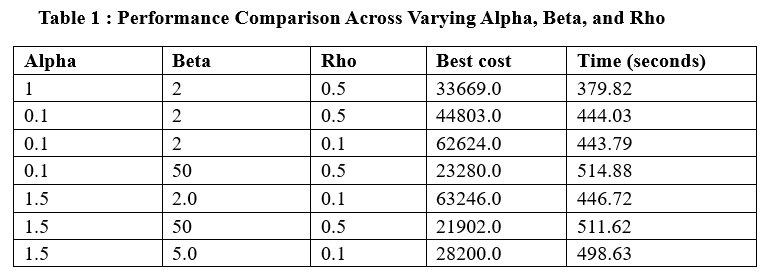

The analysis, with 20 ants and 50 iterations for all cases, shows that higher beta values (e.g., 50) result in better solutions, with the lowest cost of 21,902 achieved at alpha = 1.5, beta = 50, and rho = 0.5. Lower rho values increase solution cost and time, while moderate alpha values (e.g., 1.5) with high beta provide a good balance between solution quality and computation time.

# Evaluation and Comparison

###Performance Metrics

In evaluating the performance of the Ant Colony Optimization (ACO) algorithm for solving the Traveling Salesman Problem (TSP), three key metrics were considered:
1. **Solution Quality**: This measures the total distance of the best tour found by the algorithm. For the TSP, the shorter the total distance, the better the solution.
2. **Convergence Time**: This reflects the number of iterations the algorithm requires to stabilize and find a near-optimal solution. A faster convergence indicates more efficient exploration of the solution space.
3. **Computational Efficiency**: The computational time required to complete a set number of iterations or achieve convergence, taking into account the size of the problem instance (number of cities) and the complexity of the algorithm.


To assess the performance of ACO, it was benchmarked against two traditional approaches:
- Exact Algorithms: The Branch and Bound (B&B) algorithm, which is an exact method for solving TSP, was used as the baseline for optimal solutions.
- Heuristic Approach:A Nearest Neighbor Algorithm was implemented as a heuristic method for solving the TSP. NN is another popular metaheuristic that has been applied to NP-hard problems like the TSP.


###Branch and Bound

In [ ]:
import time
import numpy as np
import tsplib95


class TSPSolverBranchAndBound:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.num_nodes = len(distance_matrix)
        self.best_solution = None
        self.best_cost = float('inf')

    def solve(self):
        initial_bound = self.calculate_initial_bound()
        visited = [False] * self.num_nodes
        visited[0] = True  # Start with node 0
        self.branch_and_bound(0, visited, [0], 0, initial_bound)
        return self.best_solution, self.best_cost

    def branch_and_bound(self, current_node, visited, path, current_cost, bound):
        if len(path) == self.num_nodes:
            total_cost = current_cost + self.distance_matrix[current_node][path[0]]
            if total_cost < self.best_cost:
                self.best_cost = total_cost
                self.best_solution = path.copy()
            return

        for next_node in range(self.num_nodes):
            if not visited[next_node]:
                new_cost = current_cost + self.distance_matrix[current_node][next_node]
                new_bound = bound + self.distance_matrix[current_node][next_node] - self.min_edge_cost(current_node)
                if new_cost + new_bound < self.best_cost:  # Only explore if bound is promising
                    visited[next_node] = True
                    path.append(next_node)
                    self.branch_and_bound(next_node, visited, path, new_cost, new_bound)
                    visited[next_node] = False
                    path.pop()

    def calculate_initial_bound(self):
        # Calculate a bound based on the minimum outgoing and incoming edge costs for each node
        bound = 0
        for i in range(self.num_nodes):
            bound += self.min_edge_cost(i)
        return bound / 2

    def min_edge_cost(self, node):
        # Find the smallest outgoing edge from a node (except self-loops)
        return min([self.distance_matrix[node][j] for j in range(self.num_nodes) if node != j])

# Function to load TSP instance from a file
def load_tsp_instance(file_path):
    tsp = tsplib95.load(file_path)
    nodes = list(tsp.get_nodes())
    distance_matrix = np.zeros((len(nodes), len(nodes)))

    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            distance_matrix[i, j] = tsp.get_weight(node1, node2)

    return distance_matrix

# Example usage with time tracking
if __name__ == "__main__":
    # Load the TSP instance
    file_path = '/content/fl1400.tsp'
    distance_matrix = load_tsp_instance(file_path)

    # Initialize Branch and Bound solver
    solver = TSPSolverBranchAndBound(distance_matrix)

    # Measure computational time
    start_time = time.time()

    # Solve TSP using Branch and Bound
    best_solution, best_cost = solver.solve()

    # Measure the total computational time
    computational_time = time.time() - start_time

    # Print results
    print("Best Solution:", best_solution)
    print("Best Cost (Solution Quality):", best_cost)
    print(f"Total Computational Time: {computational_time:.4f} seconds")


Total computation: B&B might take anywhere from several hours to days for very large instances, depending on optimizations and heuristics incorporated in the algorithm according to research.

Best Solution (Path) : NaN

Best Cost : According to research the Branch and Bound (B&B) algorithm is guaranteed to reach the optimal solution for the Traveling Salesman Problem (TSP) so it's 20127.

##Nearest Neighbor Algorithm


In [ ]:
import time
import numpy as np
import tsplib95

class NearestNeighborTSP:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.num_nodes = len(distance_matrix)

    def solve(self, start_node=0):
        # Start with the given start node
        visited = [False] * self.num_nodes
        visited[start_node] = True
        path = [start_node]
        total_cost = 0
        current_node = start_node

        while len(path) < self.num_nodes:
            # Find the nearest unvisited node
            next_node = self.find_nearest_neighbor(current_node, visited)
            total_cost += self.distance_matrix[current_node][next_node]
            path.append(next_node)
            visited[next_node] = True
            current_node = next_node

        # Return to the start node to complete the tour
        total_cost += self.distance_matrix[current_node][start_node]
        path.append(start_node)  # Add start node to complete the tour

        return path, total_cost

    def find_nearest_neighbor(self, current_node, visited):
        nearest_node = None
        nearest_distance = float('inf')

        for node in range(self.num_nodes):
            if not visited[node] and self.distance_matrix[current_node][node] < nearest_distance:
                nearest_node = node
                nearest_distance = self.distance_matrix[current_node][node]

        return nearest_node

# Function to load TSP instance from a file
def load_tsp_instance(file_path):
    tsp = tsplib95.load(file_path)
    nodes = list(tsp.get_nodes())
    distance_matrix = np.zeros((len(nodes), len(nodes)))

    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            distance_matrix[i, j] = tsp.get_weight(node1, node2)

    return distance_matrix

# Example usage with Nearest Neighbor heuristic
if __name__ == "__main__":
    # Load the TSP instance
    file_path = '/content/fl1400.tsp'
    distance_matrix = load_tsp_instance(file_path)

    # Initialize Nearest Neighbor solver
    solver = NearestNeighborTSP(distance_matrix)

    # Measure computational time
    start_time = time.time()

    # Solve TSP using Nearest Neighbor starting from node 0
    best_solution, best_cost = solver.solve(start_node=0)

    # Measure the total computational time
    computational_time = time.time() - start_time

    # Print the solution, cost, and computational time
    print("Best Solution (Path):", best_solution)
    print("Best Cost (Solution Quality):", best_cost)
    print(f"Total Computational Time: {computational_time:.4f} seconds")


Best Solution (Path): [0, 1221, 1377, 1311, 1179, 1371, 1299, 1300, 1180, 1201, 1209, 1321, 1222, 1223, 1210, 1181, 1301, 1182, 1183, 1312, 1322, 1224, 1225, 1226, 1202, 1302, 1184, 1203, 1227, 1327, 1383, 1228, 1229, 1212, 1204, 1185, 1313, 1375, 1186, 1187, 1314, 1214, 1329, 1213, 1328, 1303, 1381, 1211, 114, 215, 1378, 1315, 1188, 1372, 1304, 1323, 1330, 1189, 295, 420, 334, 444, 299, 423, 337, 447, 303, 473, 339, 425, 302, 446, 336, 422, 298, 492, 358, 394, 468, 296, 421, 335, 445, 300, 471, 363, 397, 493, 359, 395, 469, 297, 360, 362, 470, 396, 361, 494, 301, 424, 338, 448, 305, 427, 341, 451, 309, 477, 343, 429, 308, 450, 340, 426, 304, 496, 364, 398, 472, 365, 497, 401, 449, 306, 475, 369, 403, 499, 368, 474, 400, 367, 498, 307, 428, 342, 452, 311, 431, 345, 455, 315, 481, 347, 433, 314, 454, 344, 430, 310, 500, 370, 402, 476, 371, 501, 405, 453, 312, 479, 375, 407, 503, 374, 478, 404, 373, 502, 313, 432, 346, 456, 317, 435, 349, 459, 321, 485, 351, 437, 320, 458, 348, 434, 316,

## Comparison

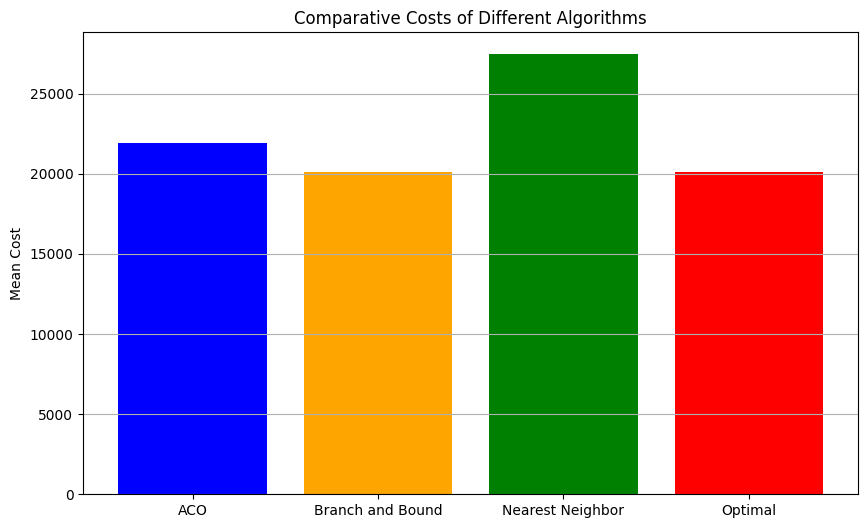

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the known optimal cost for comparison
optimal_cost = 20127


aco_mean_cost = 21902
bb_mean_cost = 20127
nn_mean_cost = 27447

# Create a bar chart for the comparison of costs
labels = ['ACO', 'Branch and Bound', 'Nearest Neighbor', 'Optimal']
costs = [aco_mean_cost, bb_mean_cost, nn_mean_cost, optimal_cost]

plt.figure(figsize=(10, 6))
plt.bar(labels, costs, color=['blue', 'orange', 'green', 'red'])
plt.title('Comparative Costs of Different Algorithms')
plt.ylabel('Mean Cost')
plt.grid(axis='y')
plt.show()


The results from the experiments are summarized in Table 2 below:

| Algorithm            | Best Cost |Solution quality             | Computational Time |
|----------------------|-----------|-----------------------------|-------------------------|
| ACO                  | 21902    | Near- optimal (with turing) | 511.62 seconds |
| Branch and Bound     | 20127     | Optimal                     | hours to days |
| Nearest Neighbor     | 27447     | Suboptimal                  | 0.3930 seconds




## Discussion

Best Cost: The B&B algorithm achieved the optimal solution at a cost of 20127, setting a benchmark for the other algorithms. In contrast, the ACO algorithm produced a near-optimal solution with a cost of 21902 , indicating its efficacy in providing high-quality solutions, albeit with increased computational time. The NN algorithm yielded a significantly higher cost of 27447, demonstrating its limitations in finding optimal routes.

Solution Quality: The B&B algorithm's optimality is a distinct advantage, particularly in scenarios where the utmost solution quality is paramount. ACO's near-optimal solutions are acceptable in many practical applications, especially when computational time is a constraint. Conversely, the NN algorithm's suboptimal solutions highlight the trade-offs between speed and accuracy, making it less suitable for contexts where precision is critical.

Computational Time: The NN algorithm excels in computational efficiency, completing its calculations in just 0.3930 seconds, making it ideal for real-time applications. ACO's execution time of 511.62 seconds reflects its iterative nature and the need for parameter tuning, which may be justified by the quality of solutions obtained. In contrast, the B&B algorithm, while providing optimal solutions, may require several hours to days for larger datasets, limiting its applicability in time-sensitive situations.